In [1]:
import os
import sys
import shutil

glp = os.path.abspath("../code")
if not glp in sys.path: sys.path.append( glp )

from global_paths import global_paths

if not global_paths["COBS"] in sys.path: sys.path.append( global_paths["COBS"] )

In [2]:
import cobs
import torch
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from copy import deepcopy

In [3]:
from BuildingOccupancy import Person, Meeting, WeeklyMeeting, OneTimeMeeting, BuildingOccupancy
from DefaultBuildings import Building_5ZoneAirCooled
from Agents import agent_constructor
from CentralController import ddpg_episode
import RLCritics
import StateUtilities as SU

Documentation: https://cobs-platform.github.io/

<h3>Define the model</h3>

In [4]:
cobs.Model.set_energyplus_folder(global_paths["eplus"])

In [5]:
building = Building_5ZoneAirCooled()

In [6]:
building_occ = BuildingOccupancy()
building_occ.set_room_settings(building.room_names[:-1], {building.room_names[-1]: 40}, 40)

In [7]:
building_occ.generate_random_occupants(60)

60

In [8]:
building_occ.generate_random_meetings(10,10)

(6, 10)

<h3>Define the agents (and the controlled devices)</h3>

In [9]:
agents = []
# HINT: a device can be a zone, too
for agent_name, (controlled_device, controlled_device_type) in building.agent_device_pairing.items():
    new_agent = agent_constructor( controlled_device_type )
    new_agent.initialize(name = agent_name)
    agents.append(new_agent)

In [10]:
building.agent_device_pairing

{'Agent SPACE1-1': ('SPACE1-1', 'VAV with Reheat,Heating,Cooling,RL'),
 'Agent SPACE2-1': ('SPACE2-1', 'VAV with Reheat,Heating,Cooling,RL'),
 'Agent SPACE3-1': ('SPACE3-1', 'VAV with Reheat,Heating,Cooling,RL'),
 'Agent SPACE4-1': ('SPACE4-1', 'VAV with Reheat,Heating,Cooling,RL'),
 'Agent SPACE5-1': ('SPACE5-1', 'VAV with Reheat,Heating,Cooling,RL')}

<h4>Define the critic</h4>

In [11]:
ciritic_input_variables=["Minutes of Day","Day of Week","Calendar Week",
                         "Outdoor Air Temperature","Outdoor Air Humidity",
                         "Outdoor Wind Speed","Outdoor Wind Direction",
                         "Outdoor Solar Radi Diffuse","Outdoor Solar Radi Direct"]
for vartype in ["Zone Temperature","Zone People Count","Zone Relative Humidity",
                "Zone VAV Reheat Damper Position","Zone CO2"]:
    ciritic_input_variables.extend( [f"SPACE{k}-1 {vartype}" for k in range(1,6)] )

In [12]:
critic = RLCritics.CriticMergeAndOnlyFC(hidden_size = 15,
                                        input_variables=ciritic_input_variables,
                                        agents = agents)

In [13]:
critic.agent_variables

['Agent SPACE1-1 Zone VAV Reheat Damper Position',
 'Agent SPACE1-1 Zone Heating/Cooling-Mean Setpoint',
 'Agent SPACE1-1 Zone Heating/Cooling-Delta Setpoint',
 'Agent SPACE2-1 Zone VAV Reheat Damper Position',
 'Agent SPACE2-1 Zone Heating/Cooling-Mean Setpoint',
 'Agent SPACE2-1 Zone Heating/Cooling-Delta Setpoint',
 'Agent SPACE3-1 Zone VAV Reheat Damper Position',
 'Agent SPACE3-1 Zone Heating/Cooling-Mean Setpoint',
 'Agent SPACE3-1 Zone Heating/Cooling-Delta Setpoint',
 'Agent SPACE4-1 Zone VAV Reheat Damper Position',
 'Agent SPACE4-1 Zone Heating/Cooling-Mean Setpoint',
 'Agent SPACE4-1 Zone Heating/Cooling-Delta Setpoint',
 'Agent SPACE5-1 Zone VAV Reheat Damper Position',
 'Agent SPACE5-1 Zone Heating/Cooling-Mean Setpoint',
 'Agent SPACE5-1 Zone Heating/Cooling-Delta Setpoint']

<h3>Set model parameters</h3>

In [14]:
#model.set_runperiod(365, 2020, 1, 1)
building.model.set_runperiod(30, 2020, 7, 1)
##building.model.set_runperiod(12, 2020, 7, 1)
#model.set_runperiod(30, 1915, 12, 12, specify_year=True)

In [15]:
building.model.set_timestep(12) # 5 Min interval, 12 steps per hour

<h4>Prepare the simulation</h4>

In [16]:
#print(building.model.get_sub_configuration("Output:Variable"))
#building.model.get_configuration("Output:Variable")

In [17]:
episode_output_lists = []

<h3>Run the simulation</h3>

In [19]:
n_episode_runs = 80
output_lists = {
    "episode_list": [],
    "timestamp_list": [],
    "loss_list": [],

    "room_temp_list": [],
    "outd_temp_list": [],
    "outd_humi_list": [],
    "outd_solar_radi_list": [],
    "outd_wspeed_list": [],
    "outd_wdir_list": [],
    "occupancy_list": [],
    "humidity_list": [],
    "co2_ppm_list": [],
    "energy_list": [],
    "rewards_list": [],
    "n_manual_stp_ch_list": [],

    "vav_pos_list": []
}

In [ ]:
for n_episode in range(n_episode_runs):
    ddpg_episode(building, building_occ, agents, critic, output_lists, n_episode)

/home/daniel/pyenvs/mastarbvenv/lib/python3.7/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


episode   0, timestep    20: 1986-07-01 01:45:00
episode   0, timestep    40: 1986-07-01 03:24:00
episode   0, timestep    60: 1986-07-01 05:04:00
episode   0, timestep    80: 1986-07-01 06:45:00
episode   0, timestep   100: 1986-07-01 08:24:00
episode   0, timestep   120: 1986-07-01 10:05:00
episode   0, timestep   140: 1986-07-01 11:45:00
episode   0, timestep   160: 1986-07-01 13:24:00
episode   0, timestep   180: 1986-07-01 15:05:00
episode   0, timestep   200: 1986-07-01 16:45:00
episode   0, timestep   220: 1986-07-01 18:25:00
episode   0, timestep   240: 1986-07-01 20:04:00
episode   0, timestep   260: 1986-07-01 21:45:00
episode   0, timestep   280: 1986-07-01 23:25:00
episode   0, timestep   300: 1986-07-02 01:04:00
episode   0, timestep   320: 1986-07-02 02:45:00
episode   0, timestep   340: 1986-07-02 04:25:00
episode   0, timestep   360: 1986-07-02 06:04:00
episode   0, timestep   380: 1986-07-02 07:45:00
episode   0, timestep   400: 1986-07-02 09:24:00
episode   0, timeste

episode   0, timestep  3380: 1986-07-12 17:45:00
episode   0, timestep  3400: 1986-07-12 19:25:00
episode   0, timestep  3420: 1986-07-12 21:04:00
episode   0, timestep  3440: 1986-07-12 22:45:00
episode   0, timestep  3460: 1986-07-13 00:24:00
episode   0, timestep  3480: 1986-07-13 02:05:00
episode   0, timestep  3500: 1986-07-13 03:45:00
episode   0, timestep  3520: 1986-07-13 05:25:00
episode   0, timestep  3540: 1986-07-13 07:04:00
episode   0, timestep  3560: 1986-07-13 08:45:00
episode   0, timestep  3580: 1986-07-13 10:24:00
episode   0, timestep  3600: 1986-07-13 12:05:00
episode   0, timestep  3620: 1986-07-13 13:45:00
episode   0, timestep  3640: 1986-07-13 15:24:00
episode   0, timestep  3660: 1986-07-13 17:04:00
episode   0, timestep  3680: 1986-07-13 18:45:00
episode   0, timestep  3700: 1986-07-13 20:25:00
episode   0, timestep  3720: 1986-07-13 22:04:00
episode   0, timestep  3740: 1986-07-13 23:45:00
episode   0, timestep  3760: 1986-07-14 01:24:00
episode   0, timeste

episode   0, timestep  6740: 1986-07-24 09:45:00
episode   0, timestep  6760: 1986-07-24 11:24:00
episode   0, timestep  6780: 1986-07-24 13:05:00
episode   0, timestep  6800: 1986-07-24 14:45:00
episode   0, timestep  6820: 1986-07-24 16:25:00
episode   0, timestep  6840: 1986-07-24 18:04:00
episode   0, timestep  6860: 1986-07-24 19:45:00
episode   0, timestep  6880: 1986-07-24 21:25:00
episode   0, timestep  6900: 1986-07-24 23:04:00
episode   0, timestep  6920: 1986-07-25 00:45:00
episode   0, timestep  6940: 1986-07-25 02:24:00
episode   0, timestep  6960: 1986-07-25 04:04:00
episode   0, timestep  6980: 1986-07-25 05:45:00
episode   0, timestep  7000: 1986-07-25 07:25:00
episode   0, timestep  7020: 1986-07-25 09:05:00
episode   0, timestep  7040: 1986-07-25 10:45:00
episode   0, timestep  7060: 1986-07-25 12:24:00
episode   0, timestep  7080: 1986-07-25 14:05:00
episode   0, timestep  7100: 1986-07-25 15:45:00
episode   0, timestep  7120: 1986-07-25 17:25:00
episode   0, timeste

episode   1, timestep  1480: 1986-07-06 03:24:00
episode   1, timestep  1500: 1986-07-06 05:04:00
episode   1, timestep  1520: 1986-07-06 06:45:00
episode   1, timestep  1540: 1986-07-06 08:24:00
episode   1, timestep  1560: 1986-07-06 10:05:00
episode   1, timestep  1580: 1986-07-06 11:45:00
episode   1, timestep  1600: 1986-07-06 13:24:00
episode   1, timestep  1620: 1986-07-06 15:05:00
episode   1, timestep  1640: 1986-07-06 16:45:00
episode   1, timestep  1660: 1986-07-06 18:25:00
episode   1, timestep  1680: 1986-07-06 20:04:00
episode   1, timestep  1700: 1986-07-06 21:45:00
episode   1, timestep  1720: 1986-07-06 23:25:00
episode   1, timestep  1740: 1986-07-07 01:04:00
episode   1, timestep  1760: 1986-07-07 02:45:00
episode   1, timestep  1780: 1986-07-07 04:25:00
episode   1, timestep  1800: 1986-07-07 06:04:00
episode   1, timestep  1820: 1986-07-07 07:45:00
episode   1, timestep  1840: 1986-07-07 09:24:00
episode   1, timestep  1860: 1986-07-07 11:05:00
episode   1, timeste

episode   1, timestep  4840: 1986-07-17 19:25:00
episode   1, timestep  4860: 1986-07-17 21:04:00
episode   1, timestep  4880: 1986-07-17 22:45:00
episode   1, timestep  4900: 1986-07-18 00:24:00
episode   1, timestep  4920: 1986-07-18 02:05:00
episode   1, timestep  4940: 1986-07-18 03:45:00
episode   1, timestep  4960: 1986-07-18 05:25:00
episode   1, timestep  4980: 1986-07-18 07:04:00
episode   1, timestep  5000: 1986-07-18 08:45:00
episode   1, timestep  5020: 1986-07-18 10:24:00
episode   1, timestep  5040: 1986-07-18 12:05:00
episode   1, timestep  5060: 1986-07-18 13:45:00
episode   1, timestep  5080: 1986-07-18 15:24:00
episode   1, timestep  5100: 1986-07-18 17:04:00
episode   1, timestep  5120: 1986-07-18 18:45:00
episode   1, timestep  5140: 1986-07-18 20:25:00
episode   1, timestep  5160: 1986-07-18 22:04:00
episode   1, timestep  5180: 1986-07-18 23:45:00
episode   1, timestep  5200: 1986-07-19 01:24:00
episode   1, timestep  5220: 1986-07-19 03:05:00
episode   1, timeste

episode   1, timestep  8200: 1986-07-29 11:24:00
episode   1, timestep  8220: 1986-07-29 13:05:00
episode   1, timestep  8240: 1986-07-29 14:45:00
episode   1, timestep  8260: 1986-07-29 16:25:00
episode   1, timestep  8280: 1986-07-29 18:04:00
episode   1, timestep  8300: 1986-07-29 19:45:00
episode   1, timestep  8320: 1986-07-29 21:25:00
episode   1, timestep  8340: 1986-07-29 23:04:00
episode   1, timestep  8360: 1986-07-30 00:45:00
episode   1, timestep  8380: 1986-07-30 02:24:00
episode   1, timestep  8400: 1986-07-30 04:04:00
episode   1, timestep  8420: 1986-07-30 05:45:00
episode   1, timestep  8440: 1986-07-30 07:25:00
episode   1, timestep  8460: 1986-07-30 09:05:00
episode   1, timestep  8480: 1986-07-30 10:45:00
episode   1, timestep  8500: 1986-07-30 12:24:00
episode   1, timestep  8520: 1986-07-30 14:05:00
episode   1, timestep  8540: 1986-07-30 15:45:00
episode   1, timestep  8560: 1986-07-30 17:25:00
episode   1, timestep  8580: 1986-07-30 19:04:00
episode   1, timeste

episode   2, timestep  2940: 1986-07-11 05:04:00
episode   2, timestep  2960: 1986-07-11 06:45:00
episode   2, timestep  2980: 1986-07-11 08:24:00
episode   2, timestep  3000: 1986-07-11 10:05:00
episode   2, timestep  3020: 1986-07-11 11:45:00
episode   2, timestep  3040: 1986-07-11 13:24:00
episode   2, timestep  3060: 1986-07-11 15:05:00
episode   2, timestep  3080: 1986-07-11 16:45:00
episode   2, timestep  3100: 1986-07-11 18:25:00
episode   2, timestep  3120: 1986-07-11 20:04:00
episode   2, timestep  3140: 1986-07-11 21:45:00
episode   2, timestep  3160: 1986-07-11 23:25:00
episode   2, timestep  3180: 1986-07-12 01:04:00
episode   2, timestep  3200: 1986-07-12 02:45:00
episode   2, timestep  3220: 1986-07-12 04:25:00
episode   2, timestep  3240: 1986-07-12 06:04:00
episode   2, timestep  3260: 1986-07-12 07:45:00
episode   2, timestep  3280: 1986-07-12 09:24:00
episode   2, timestep  3300: 1986-07-12 11:05:00
episode   2, timestep  3320: 1986-07-12 12:45:00
episode   2, timeste

episode   2, timestep  6300: 1986-07-22 21:04:00
episode   2, timestep  6320: 1986-07-22 22:45:00
episode   2, timestep  6340: 1986-07-23 00:24:00
episode   2, timestep  6360: 1986-07-23 02:05:00
episode   2, timestep  6380: 1986-07-23 03:45:00
episode   2, timestep  6400: 1986-07-23 05:25:00
episode   2, timestep  6420: 1986-07-23 07:04:00
episode   2, timestep  6440: 1986-07-23 08:45:00
episode   2, timestep  6460: 1986-07-23 10:24:00
episode   2, timestep  6480: 1986-07-23 12:05:00
episode   2, timestep  6500: 1986-07-23 13:45:00
episode   2, timestep  6520: 1986-07-23 15:24:00
episode   2, timestep  6540: 1986-07-23 17:04:00
episode   2, timestep  6560: 1986-07-23 18:45:00
episode   2, timestep  6580: 1986-07-23 20:25:00
episode   2, timestep  6600: 1986-07-23 22:04:00
episode   2, timestep  6620: 1986-07-23 23:45:00
episode   2, timestep  6640: 1986-07-24 01:24:00
episode   2, timestep  6660: 1986-07-24 03:05:00
episode   2, timestep  6680: 1986-07-24 04:45:00
episode   2, timeste

episode   3, timestep  1040: 1986-07-04 14:45:00
episode   3, timestep  1060: 1986-07-04 16:25:00
episode   3, timestep  1080: 1986-07-04 18:04:00
episode   3, timestep  1100: 1986-07-04 19:45:00
episode   3, timestep  1120: 1986-07-04 21:25:00
episode   3, timestep  1140: 1986-07-04 23:04:00
episode   3, timestep  1160: 1986-07-05 00:45:00
episode   3, timestep  1180: 1986-07-05 02:24:00
episode   3, timestep  1200: 1986-07-05 04:04:00
episode   3, timestep  1220: 1986-07-05 05:45:00
episode   3, timestep  1240: 1986-07-05 07:25:00
episode   3, timestep  1260: 1986-07-05 09:05:00
episode   3, timestep  1280: 1986-07-05 10:45:00
episode   3, timestep  1300: 1986-07-05 12:24:00
episode   3, timestep  1320: 1986-07-05 14:05:00
episode   3, timestep  1340: 1986-07-05 15:45:00
episode   3, timestep  1360: 1986-07-05 17:25:00
episode   3, timestep  1380: 1986-07-05 19:04:00
episode   3, timestep  1400: 1986-07-05 20:45:00
episode   3, timestep  1420: 1986-07-05 22:25:00
episode   3, timeste

episode   3, timestep  4400: 1986-07-16 06:45:00
episode   3, timestep  4420: 1986-07-16 08:24:00
episode   3, timestep  4440: 1986-07-16 10:05:00
episode   3, timestep  4460: 1986-07-16 11:45:00
episode   3, timestep  4480: 1986-07-16 13:24:00
episode   3, timestep  4500: 1986-07-16 15:05:00
episode   3, timestep  4520: 1986-07-16 16:45:00
episode   3, timestep  4540: 1986-07-16 18:25:00
episode   3, timestep  4560: 1986-07-16 20:04:00
episode   3, timestep  4580: 1986-07-16 21:45:00
episode   3, timestep  4600: 1986-07-16 23:25:00
episode   3, timestep  4620: 1986-07-17 01:04:00
episode   3, timestep  4640: 1986-07-17 02:45:00
episode   3, timestep  4660: 1986-07-17 04:25:00
episode   3, timestep  4680: 1986-07-17 06:04:00
episode   3, timestep  4700: 1986-07-17 07:45:00
episode   3, timestep  4720: 1986-07-17 09:24:00
episode   3, timestep  4740: 1986-07-17 11:05:00
episode   3, timestep  4760: 1986-07-17 12:45:00
episode   3, timestep  4780: 1986-07-17 14:24:00
episode   3, timeste

episode   3, timestep  7760: 1986-07-27 22:45:00
episode   3, timestep  7780: 1986-07-28 00:24:00
episode   3, timestep  7800: 1986-07-28 02:05:00
episode   3, timestep  7820: 1986-07-28 03:45:00
episode   3, timestep  7840: 1986-07-28 05:25:00
episode   3, timestep  7860: 1986-07-28 07:04:00
episode   3, timestep  7880: 1986-07-28 08:45:00
episode   3, timestep  7900: 1986-07-28 10:24:00
episode   3, timestep  7920: 1986-07-28 12:05:00
episode   3, timestep  7940: 1986-07-28 13:45:00
episode   3, timestep  7960: 1986-07-28 15:24:00
episode   3, timestep  7980: 1986-07-28 17:04:00
episode   3, timestep  8000: 1986-07-28 18:45:00
episode   3, timestep  8020: 1986-07-28 20:25:00
episode   3, timestep  8040: 1986-07-28 22:04:00
episode   3, timestep  8060: 1986-07-28 23:45:00
episode   3, timestep  8080: 1986-07-29 01:24:00
episode   3, timestep  8100: 1986-07-29 03:05:00
episode   3, timestep  8120: 1986-07-29 04:45:00
episode   3, timestep  8140: 1986-07-29 06:25:00
episode   3, timeste

episode   4, timestep  2500: 1986-07-09 16:25:00
episode   4, timestep  2520: 1986-07-09 18:04:00
episode   4, timestep  2540: 1986-07-09 19:45:00
episode   4, timestep  2560: 1986-07-09 21:25:00
episode   4, timestep  2580: 1986-07-09 23:04:00
episode   4, timestep  2600: 1986-07-10 00:45:00
episode   4, timestep  2620: 1986-07-10 02:24:00
episode   4, timestep  2640: 1986-07-10 04:04:00
episode   4, timestep  2660: 1986-07-10 05:45:00
episode   4, timestep  2680: 1986-07-10 07:25:00
episode   4, timestep  2700: 1986-07-10 09:05:00
episode   4, timestep  2720: 1986-07-10 10:45:00
episode   4, timestep  2740: 1986-07-10 12:24:00
episode   4, timestep  2760: 1986-07-10 14:05:00
episode   4, timestep  2780: 1986-07-10 15:45:00
episode   4, timestep  2800: 1986-07-10 17:25:00
episode   4, timestep  2820: 1986-07-10 19:04:00
episode   4, timestep  2840: 1986-07-10 20:45:00
episode   4, timestep  2860: 1986-07-10 22:25:00
episode   4, timestep  2880: 1986-07-11 00:05:00
episode   4, timeste

episode   4, timestep  5860: 1986-07-21 08:24:00
episode   4, timestep  5880: 1986-07-21 10:05:00
episode   4, timestep  5900: 1986-07-21 11:45:00
episode   4, timestep  5920: 1986-07-21 13:24:00
episode   4, timestep  5940: 1986-07-21 15:05:00
episode   4, timestep  5960: 1986-07-21 16:45:00
episode   4, timestep  5980: 1986-07-21 18:25:00
episode   4, timestep  6000: 1986-07-21 20:04:00
episode   4, timestep  6020: 1986-07-21 21:45:00
episode   4, timestep  6040: 1986-07-21 23:25:00
episode   4, timestep  6060: 1986-07-22 01:04:00
episode   4, timestep  6080: 1986-07-22 02:45:00
episode   4, timestep  6100: 1986-07-22 04:25:00
episode   4, timestep  6120: 1986-07-22 06:04:00
episode   4, timestep  6140: 1986-07-22 07:45:00
episode   4, timestep  6160: 1986-07-22 09:24:00
episode   4, timestep  6180: 1986-07-22 11:05:00
episode   4, timestep  6200: 1986-07-22 12:45:00
episode   4, timestep  6220: 1986-07-22 14:24:00
episode   4, timestep  6240: 1986-07-22 16:04:00
episode   4, timeste

episode   5, timestep   600: 1986-07-03 02:05:00
episode   5, timestep   620: 1986-07-03 03:45:00
episode   5, timestep   640: 1986-07-03 05:25:00
episode   5, timestep   660: 1986-07-03 07:04:00
episode   5, timestep   680: 1986-07-03 08:45:00
episode   5, timestep   700: 1986-07-03 10:24:00
episode   5, timestep   720: 1986-07-03 12:05:00
episode   5, timestep   740: 1986-07-03 13:45:00
episode   5, timestep   760: 1986-07-03 15:24:00
episode   5, timestep   780: 1986-07-03 17:04:00
episode   5, timestep   800: 1986-07-03 18:45:00
episode   5, timestep   820: 1986-07-03 20:25:00
episode   5, timestep   840: 1986-07-03 22:04:00
episode   5, timestep   860: 1986-07-03 23:45:00
episode   5, timestep   880: 1986-07-04 01:24:00
episode   5, timestep   900: 1986-07-04 03:05:00
episode   5, timestep   920: 1986-07-04 04:45:00
episode   5, timestep   940: 1986-07-04 06:25:00
episode   5, timestep   960: 1986-07-04 08:05:00
episode   5, timestep   980: 1986-07-04 09:45:00
episode   5, timeste

episode   5, timestep  3960: 1986-07-14 18:04:00
episode   5, timestep  3980: 1986-07-14 19:45:00
episode   5, timestep  4000: 1986-07-14 21:25:00
episode   5, timestep  4020: 1986-07-14 23:04:00
episode   5, timestep  4040: 1986-07-15 00:45:00
episode   5, timestep  4060: 1986-07-15 02:24:00
episode   5, timestep  4080: 1986-07-15 04:04:00
episode   5, timestep  4100: 1986-07-15 05:45:00
episode   5, timestep  4120: 1986-07-15 07:25:00
episode   5, timestep  4140: 1986-07-15 09:05:00
episode   5, timestep  4160: 1986-07-15 10:45:00
episode   5, timestep  4180: 1986-07-15 12:24:00
episode   5, timestep  4200: 1986-07-15 14:05:00
episode   5, timestep  4220: 1986-07-15 15:45:00
episode   5, timestep  4240: 1986-07-15 17:25:00
episode   5, timestep  4260: 1986-07-15 19:04:00
episode   5, timestep  4280: 1986-07-15 20:45:00
episode   5, timestep  4300: 1986-07-15 22:25:00
episode   5, timestep  4320: 1986-07-16 00:05:00
episode   5, timestep  4340: 1986-07-16 01:45:00
episode   5, timeste

episode   5, timestep  7320: 1986-07-26 10:05:00
episode   5, timestep  7340: 1986-07-26 11:45:00
episode   5, timestep  7360: 1986-07-26 13:24:00
episode   5, timestep  7380: 1986-07-26 15:05:00
episode   5, timestep  7400: 1986-07-26 16:45:00
episode   5, timestep  7420: 1986-07-26 18:25:00
episode   5, timestep  7440: 1986-07-26 20:04:00
episode   5, timestep  7460: 1986-07-26 21:45:00
episode   5, timestep  7480: 1986-07-26 23:25:00
episode   5, timestep  7500: 1986-07-27 01:04:00
episode   5, timestep  7520: 1986-07-27 02:45:00
episode   5, timestep  7540: 1986-07-27 04:25:00
episode   5, timestep  7560: 1986-07-27 06:04:00
episode   5, timestep  7580: 1986-07-27 07:45:00
episode   5, timestep  7600: 1986-07-27 09:24:00
episode   5, timestep  7620: 1986-07-27 11:05:00
episode   5, timestep  7640: 1986-07-27 12:45:00
episode   5, timestep  7660: 1986-07-27 14:24:00
episode   5, timestep  7680: 1986-07-27 16:04:00
episode   5, timestep  7700: 1986-07-27 17:45:00
episode   5, timeste

episode   6, timestep  2060: 1986-07-08 03:45:00
episode   6, timestep  2080: 1986-07-08 05:25:00
episode   6, timestep  2100: 1986-07-08 07:04:00
episode   6, timestep  2120: 1986-07-08 08:45:00
episode   6, timestep  2140: 1986-07-08 10:24:00
episode   6, timestep  2160: 1986-07-08 12:05:00
episode   6, timestep  2180: 1986-07-08 13:45:00
episode   6, timestep  2200: 1986-07-08 15:24:00
episode   6, timestep  2220: 1986-07-08 17:04:00
episode   6, timestep  2240: 1986-07-08 18:45:00
episode   6, timestep  2260: 1986-07-08 20:25:00
episode   6, timestep  2280: 1986-07-08 22:04:00
episode   6, timestep  2300: 1986-07-08 23:45:00
episode   6, timestep  2320: 1986-07-09 01:24:00
episode   6, timestep  2340: 1986-07-09 03:05:00
episode   6, timestep  2360: 1986-07-09 04:45:00
episode   6, timestep  2380: 1986-07-09 06:25:00
episode   6, timestep  2400: 1986-07-09 08:05:00
episode   6, timestep  2420: 1986-07-09 09:45:00
episode   6, timestep  2440: 1986-07-09 11:24:00
episode   6, timeste

episode   6, timestep  5420: 1986-07-19 19:45:00
episode   6, timestep  5440: 1986-07-19 21:25:00
episode   6, timestep  5460: 1986-07-19 23:04:00
episode   6, timestep  5480: 1986-07-20 00:45:00
episode   6, timestep  5500: 1986-07-20 02:24:00
episode   6, timestep  5520: 1986-07-20 04:04:00
episode   6, timestep  5540: 1986-07-20 05:45:00
episode   6, timestep  5560: 1986-07-20 07:25:00
episode   6, timestep  5580: 1986-07-20 09:05:00
episode   6, timestep  5600: 1986-07-20 10:45:00
episode   6, timestep  5620: 1986-07-20 12:24:00
episode   6, timestep  5640: 1986-07-20 14:05:00
episode   6, timestep  5660: 1986-07-20 15:45:00
episode   6, timestep  5680: 1986-07-20 17:25:00
episode   6, timestep  5700: 1986-07-20 19:04:00
episode   6, timestep  5720: 1986-07-20 20:45:00
episode   6, timestep  5740: 1986-07-20 22:25:00
episode   6, timestep  5760: 1986-07-21 00:05:00
episode   6, timestep  5780: 1986-07-21 01:45:00
episode   6, timestep  5800: 1986-07-21 03:24:00
episode   6, timeste

episode   7, timestep   160: 1986-07-01 13:24:00
episode   7, timestep   180: 1986-07-01 15:05:00
episode   7, timestep   200: 1986-07-01 16:45:00
episode   7, timestep   220: 1986-07-01 18:25:00
episode   7, timestep   240: 1986-07-01 20:04:00
episode   7, timestep   260: 1986-07-01 21:45:00
episode   7, timestep   280: 1986-07-01 23:25:00
episode   7, timestep   300: 1986-07-02 01:04:00
episode   7, timestep   320: 1986-07-02 02:45:00
episode   7, timestep   340: 1986-07-02 04:25:00
episode   7, timestep   360: 1986-07-02 06:04:00
episode   7, timestep   380: 1986-07-02 07:45:00
episode   7, timestep   400: 1986-07-02 09:24:00
episode   7, timestep   420: 1986-07-02 11:05:00
episode   7, timestep   440: 1986-07-02 12:45:00
episode   7, timestep   460: 1986-07-02 14:24:00
episode   7, timestep   480: 1986-07-02 16:04:00
episode   7, timestep   500: 1986-07-02 17:45:00
episode   7, timestep   520: 1986-07-02 19:25:00
episode   7, timestep   540: 1986-07-02 21:04:00
episode   7, timeste

episode   7, timestep  3520: 1986-07-13 05:25:00
episode   7, timestep  3540: 1986-07-13 07:04:00
episode   7, timestep  3560: 1986-07-13 08:45:00
episode   7, timestep  3580: 1986-07-13 10:24:00
episode   7, timestep  3600: 1986-07-13 12:05:00
episode   7, timestep  3620: 1986-07-13 13:45:00
episode   7, timestep  3640: 1986-07-13 15:24:00
episode   7, timestep  3660: 1986-07-13 17:04:00
episode   7, timestep  3680: 1986-07-13 18:45:00
episode   7, timestep  3700: 1986-07-13 20:25:00
episode   7, timestep  3720: 1986-07-13 22:04:00
episode   7, timestep  3740: 1986-07-13 23:45:00
episode   7, timestep  3760: 1986-07-14 01:24:00
episode   7, timestep  3780: 1986-07-14 03:05:00
episode   7, timestep  3800: 1986-07-14 04:45:00
episode   7, timestep  3820: 1986-07-14 06:25:00
episode   7, timestep  3840: 1986-07-14 08:05:00
episode   7, timestep  3860: 1986-07-14 09:45:00
episode   7, timestep  3880: 1986-07-14 11:24:00
episode   7, timestep  3900: 1986-07-14 13:05:00
episode   7, timeste

episode   7, timestep  6880: 1986-07-24 21:25:00
episode   7, timestep  6900: 1986-07-24 23:04:00
episode   7, timestep  6920: 1986-07-25 00:45:00
episode   7, timestep  6940: 1986-07-25 02:24:00
episode   7, timestep  6960: 1986-07-25 04:04:00
episode   7, timestep  6980: 1986-07-25 05:45:00
episode   7, timestep  7000: 1986-07-25 07:25:00
episode   7, timestep  7020: 1986-07-25 09:05:00
episode   7, timestep  7040: 1986-07-25 10:45:00
episode   7, timestep  7060: 1986-07-25 12:24:00
episode   7, timestep  7080: 1986-07-25 14:05:00
episode   7, timestep  7100: 1986-07-25 15:45:00
episode   7, timestep  7120: 1986-07-25 17:25:00
episode   7, timestep  7140: 1986-07-25 19:04:00
episode   7, timestep  7160: 1986-07-25 20:45:00
episode   7, timestep  7180: 1986-07-25 22:25:00
episode   7, timestep  7200: 1986-07-26 00:05:00
episode   7, timestep  7220: 1986-07-26 01:45:00
episode   7, timestep  7240: 1986-07-26 03:24:00
episode   7, timestep  7260: 1986-07-26 05:04:00
episode   7, timeste

episode   8, timestep  1620: 1986-07-06 15:05:00
episode   8, timestep  1640: 1986-07-06 16:45:00
episode   8, timestep  1660: 1986-07-06 18:25:00
episode   8, timestep  1680: 1986-07-06 20:04:00
episode   8, timestep  1700: 1986-07-06 21:45:00
episode   8, timestep  1720: 1986-07-06 23:25:00
episode   8, timestep  1740: 1986-07-07 01:04:00
episode   8, timestep  1760: 1986-07-07 02:45:00
episode   8, timestep  1780: 1986-07-07 04:25:00
episode   8, timestep  1800: 1986-07-07 06:04:00
episode   8, timestep  1820: 1986-07-07 07:45:00
episode   8, timestep  1840: 1986-07-07 09:24:00
episode   8, timestep  1860: 1986-07-07 11:05:00
episode   8, timestep  1880: 1986-07-07 12:45:00
episode   8, timestep  1900: 1986-07-07 14:24:00
episode   8, timestep  1920: 1986-07-07 16:04:00
episode   8, timestep  1940: 1986-07-07 17:45:00
episode   8, timestep  1960: 1986-07-07 19:25:00
episode   8, timestep  1980: 1986-07-07 21:04:00
episode   8, timestep  2000: 1986-07-07 22:45:00
episode   8, timeste

episode   8, timestep  4980: 1986-07-18 07:04:00
episode   8, timestep  5000: 1986-07-18 08:45:00
episode   8, timestep  5020: 1986-07-18 10:24:00
episode   8, timestep  5040: 1986-07-18 12:05:00
episode   8, timestep  5060: 1986-07-18 13:45:00
episode   8, timestep  5080: 1986-07-18 15:24:00
episode   8, timestep  5100: 1986-07-18 17:04:00
episode   8, timestep  5120: 1986-07-18 18:45:00
episode   8, timestep  5140: 1986-07-18 20:25:00
episode   8, timestep  5160: 1986-07-18 22:04:00
episode   8, timestep  5180: 1986-07-18 23:45:00
episode   8, timestep  5200: 1986-07-19 01:24:00
episode   8, timestep  5220: 1986-07-19 03:05:00
episode   8, timestep  5240: 1986-07-19 04:45:00
episode   8, timestep  5260: 1986-07-19 06:25:00
episode   8, timestep  5280: 1986-07-19 08:05:00
episode   8, timestep  5300: 1986-07-19 09:45:00
episode   8, timestep  5320: 1986-07-19 11:24:00
episode   8, timestep  5340: 1986-07-19 13:05:00
episode   8, timestep  5360: 1986-07-19 14:45:00
episode   8, timeste

episode   8, timestep  8340: 1986-07-29 23:04:00
episode   8, timestep  8360: 1986-07-30 00:45:00
episode   8, timestep  8380: 1986-07-30 02:24:00
episode   8, timestep  8400: 1986-07-30 04:04:00
episode   8, timestep  8420: 1986-07-30 05:45:00
episode   8, timestep  8440: 1986-07-30 07:25:00
episode   8, timestep  8460: 1986-07-30 09:05:00
episode   8, timestep  8480: 1986-07-30 10:45:00
episode   8, timestep  8500: 1986-07-30 12:24:00
episode   8, timestep  8520: 1986-07-30 14:05:00
episode   8, timestep  8540: 1986-07-30 15:45:00
episode   8, timestep  8560: 1986-07-30 17:25:00
episode   8, timestep  8580: 1986-07-30 19:04:00
episode   8, timestep  8600: 1986-07-30 20:45:00
episode   8, timestep  8620: 1986-07-30 22:25:00
episode   9, timestep    20: 1986-07-01 01:45:00
episode   9, timestep    40: 1986-07-01 03:24:00
episode   9, timestep    60: 1986-07-01 05:04:00
episode   9, timestep    80: 1986-07-01 06:45:00
episode   9, timestep   100: 1986-07-01 08:24:00
episode   9, timeste

episode   9, timestep  3080: 1986-07-11 16:45:00
episode   9, timestep  3100: 1986-07-11 18:25:00
episode   9, timestep  3120: 1986-07-11 20:04:00
episode   9, timestep  3140: 1986-07-11 21:45:00
episode   9, timestep  3160: 1986-07-11 23:25:00
episode   9, timestep  3180: 1986-07-12 01:04:00
episode   9, timestep  3200: 1986-07-12 02:45:00
episode   9, timestep  3220: 1986-07-12 04:25:00
episode   9, timestep  3240: 1986-07-12 06:04:00
episode   9, timestep  3260: 1986-07-12 07:45:00
episode   9, timestep  3280: 1986-07-12 09:24:00
episode   9, timestep  3300: 1986-07-12 11:05:00
episode   9, timestep  3320: 1986-07-12 12:45:00
episode   9, timestep  3340: 1986-07-12 14:24:00
episode   9, timestep  3360: 1986-07-12 16:04:00
episode   9, timestep  3380: 1986-07-12 17:45:00
episode   9, timestep  3400: 1986-07-12 19:25:00
episode   9, timestep  3420: 1986-07-12 21:04:00
episode   9, timestep  3440: 1986-07-12 22:45:00
episode   9, timestep  3460: 1986-07-13 00:24:00
episode   9, timeste

episode   9, timestep  6440: 1986-07-23 08:45:00
episode   9, timestep  6460: 1986-07-23 10:24:00
episode   9, timestep  6480: 1986-07-23 12:05:00
episode   9, timestep  6500: 1986-07-23 13:45:00
episode   9, timestep  6520: 1986-07-23 15:24:00
episode   9, timestep  6540: 1986-07-23 17:04:00
episode   9, timestep  6560: 1986-07-23 18:45:00
episode   9, timestep  6580: 1986-07-23 20:25:00
episode   9, timestep  6600: 1986-07-23 22:04:00
episode   9, timestep  6620: 1986-07-23 23:45:00
episode   9, timestep  6640: 1986-07-24 01:24:00
episode   9, timestep  6660: 1986-07-24 03:05:00
episode   9, timestep  6680: 1986-07-24 04:45:00
episode   9, timestep  6700: 1986-07-24 06:25:00
episode   9, timestep  6720: 1986-07-24 08:05:00
episode   9, timestep  6740: 1986-07-24 09:45:00
episode   9, timestep  6760: 1986-07-24 11:24:00
episode   9, timestep  6780: 1986-07-24 13:05:00
episode   9, timestep  6800: 1986-07-24 14:45:00
episode   9, timestep  6820: 1986-07-24 16:25:00
episode   9, timeste

episode  10, timestep  1180: 1986-07-05 02:24:00
episode  10, timestep  1200: 1986-07-05 04:04:00
episode  10, timestep  1220: 1986-07-05 05:45:00
episode  10, timestep  1240: 1986-07-05 07:25:00
episode  10, timestep  1260: 1986-07-05 09:05:00
episode  10, timestep  1280: 1986-07-05 10:45:00
episode  10, timestep  1300: 1986-07-05 12:24:00
episode  10, timestep  1320: 1986-07-05 14:05:00
episode  10, timestep  1340: 1986-07-05 15:45:00
episode  10, timestep  1360: 1986-07-05 17:25:00
episode  10, timestep  1380: 1986-07-05 19:04:00
episode  10, timestep  1400: 1986-07-05 20:45:00
episode  10, timestep  1420: 1986-07-05 22:25:00
episode  10, timestep  1440: 1986-07-06 00:05:00
episode  10, timestep  1460: 1986-07-06 01:45:00
episode  10, timestep  1480: 1986-07-06 03:24:00
episode  10, timestep  1500: 1986-07-06 05:04:00
episode  10, timestep  1520: 1986-07-06 06:45:00
episode  10, timestep  1540: 1986-07-06 08:24:00
episode  10, timestep  1560: 1986-07-06 10:05:00
episode  10, timeste

episode  10, timestep  4540: 1986-07-16 18:25:00
episode  10, timestep  4560: 1986-07-16 20:04:00
episode  10, timestep  4580: 1986-07-16 21:45:00
episode  10, timestep  4600: 1986-07-16 23:25:00
episode  10, timestep  4620: 1986-07-17 01:04:00
episode  10, timestep  4640: 1986-07-17 02:45:00
episode  10, timestep  4660: 1986-07-17 04:25:00
episode  10, timestep  4680: 1986-07-17 06:04:00
episode  10, timestep  4700: 1986-07-17 07:45:00
episode  10, timestep  4720: 1986-07-17 09:24:00
episode  10, timestep  4740: 1986-07-17 11:05:00
episode  10, timestep  4760: 1986-07-17 12:45:00
episode  10, timestep  4780: 1986-07-17 14:24:00
episode  10, timestep  4800: 1986-07-17 16:04:00
episode  10, timestep  4820: 1986-07-17 17:45:00
episode  10, timestep  4840: 1986-07-17 19:25:00
episode  10, timestep  4860: 1986-07-17 21:04:00
episode  10, timestep  4880: 1986-07-17 22:45:00
episode  10, timestep  4900: 1986-07-18 00:24:00
episode  10, timestep  4920: 1986-07-18 02:05:00
episode  10, timeste

episode  10, timestep  7900: 1986-07-28 10:24:00
episode  10, timestep  7920: 1986-07-28 12:05:00
episode  10, timestep  7940: 1986-07-28 13:45:00
episode  10, timestep  7960: 1986-07-28 15:24:00
episode  10, timestep  7980: 1986-07-28 17:04:00
episode  10, timestep  8000: 1986-07-28 18:45:00
episode  10, timestep  8020: 1986-07-28 20:25:00
episode  10, timestep  8040: 1986-07-28 22:04:00
episode  10, timestep  8060: 1986-07-28 23:45:00
episode  10, timestep  8080: 1986-07-29 01:24:00
episode  10, timestep  8100: 1986-07-29 03:05:00
episode  10, timestep  8120: 1986-07-29 04:45:00
episode  10, timestep  8140: 1986-07-29 06:25:00
episode  10, timestep  8160: 1986-07-29 08:05:00
episode  10, timestep  8180: 1986-07-29 09:45:00
episode  10, timestep  8200: 1986-07-29 11:24:00
episode  10, timestep  8220: 1986-07-29 13:05:00
episode  10, timestep  8240: 1986-07-29 14:45:00
episode  10, timestep  8260: 1986-07-29 16:25:00
episode  10, timestep  8280: 1986-07-29 18:04:00
episode  10, timeste

episode  11, timestep  2640: 1986-07-10 04:04:00
episode  11, timestep  2660: 1986-07-10 05:45:00
episode  11, timestep  2680: 1986-07-10 07:25:00
episode  11, timestep  2700: 1986-07-10 09:05:00
episode  11, timestep  2720: 1986-07-10 10:45:00
episode  11, timestep  2740: 1986-07-10 12:24:00
episode  11, timestep  2760: 1986-07-10 14:05:00
episode  11, timestep  2780: 1986-07-10 15:45:00
episode  11, timestep  2800: 1986-07-10 17:25:00
episode  11, timestep  2820: 1986-07-10 19:04:00
episode  11, timestep  2840: 1986-07-10 20:45:00
episode  11, timestep  2860: 1986-07-10 22:25:00
episode  11, timestep  2880: 1986-07-11 00:05:00
episode  11, timestep  2900: 1986-07-11 01:45:00
episode  11, timestep  2920: 1986-07-11 03:24:00
episode  11, timestep  2940: 1986-07-11 05:04:00
episode  11, timestep  2960: 1986-07-11 06:45:00
episode  11, timestep  2980: 1986-07-11 08:24:00
episode  11, timestep  3000: 1986-07-11 10:05:00
episode  11, timestep  3020: 1986-07-11 11:45:00
episode  11, timeste

episode  11, timestep  6000: 1986-07-21 20:04:00
episode  11, timestep  6020: 1986-07-21 21:45:00
episode  11, timestep  6040: 1986-07-21 23:25:00
episode  11, timestep  6060: 1986-07-22 01:04:00
episode  11, timestep  6080: 1986-07-22 02:45:00
episode  11, timestep  6100: 1986-07-22 04:25:00
episode  11, timestep  6120: 1986-07-22 06:04:00
episode  11, timestep  6140: 1986-07-22 07:45:00
episode  11, timestep  6160: 1986-07-22 09:24:00
episode  11, timestep  6180: 1986-07-22 11:05:00
episode  11, timestep  6200: 1986-07-22 12:45:00
episode  11, timestep  6220: 1986-07-22 14:24:00
episode  11, timestep  6240: 1986-07-22 16:04:00
episode  11, timestep  6260: 1986-07-22 17:45:00
episode  11, timestep  6280: 1986-07-22 19:25:00
episode  11, timestep  6300: 1986-07-22 21:04:00
episode  11, timestep  6320: 1986-07-22 22:45:00
episode  11, timestep  6340: 1986-07-23 00:24:00
episode  11, timestep  6360: 1986-07-23 02:05:00
episode  11, timestep  6380: 1986-07-23 03:45:00
episode  11, timeste

episode  12, timestep   740: 1986-07-03 13:45:00
episode  12, timestep   760: 1986-07-03 15:24:00
episode  12, timestep   780: 1986-07-03 17:04:00
episode  12, timestep   800: 1986-07-03 18:45:00
episode  12, timestep   820: 1986-07-03 20:25:00
episode  12, timestep   840: 1986-07-03 22:04:00
episode  12, timestep   860: 1986-07-03 23:45:00
episode  12, timestep   880: 1986-07-04 01:24:00
episode  12, timestep   900: 1986-07-04 03:05:00
episode  12, timestep   920: 1986-07-04 04:45:00
episode  12, timestep   940: 1986-07-04 06:25:00
episode  12, timestep   960: 1986-07-04 08:05:00
episode  12, timestep   980: 1986-07-04 09:45:00
episode  12, timestep  1000: 1986-07-04 11:24:00
episode  12, timestep  1020: 1986-07-04 13:05:00
episode  12, timestep  1040: 1986-07-04 14:45:00
episode  12, timestep  1060: 1986-07-04 16:25:00
episode  12, timestep  1080: 1986-07-04 18:04:00
episode  12, timestep  1100: 1986-07-04 19:45:00
episode  12, timestep  1120: 1986-07-04 21:25:00
episode  12, timeste

episode  12, timestep  4100: 1986-07-15 05:45:00
episode  12, timestep  4120: 1986-07-15 07:25:00
episode  12, timestep  4140: 1986-07-15 09:05:00
episode  12, timestep  4160: 1986-07-15 10:45:00
episode  12, timestep  4180: 1986-07-15 12:24:00
episode  12, timestep  4200: 1986-07-15 14:05:00
episode  12, timestep  4220: 1986-07-15 15:45:00
episode  12, timestep  4240: 1986-07-15 17:25:00
episode  12, timestep  4260: 1986-07-15 19:04:00
episode  12, timestep  4280: 1986-07-15 20:45:00
episode  12, timestep  4300: 1986-07-15 22:25:00
episode  12, timestep  4320: 1986-07-16 00:05:00
episode  12, timestep  4340: 1986-07-16 01:45:00
episode  12, timestep  4360: 1986-07-16 03:24:00
episode  12, timestep  4380: 1986-07-16 05:04:00
episode  12, timestep  4400: 1986-07-16 06:45:00
episode  12, timestep  4420: 1986-07-16 08:24:00
episode  12, timestep  4440: 1986-07-16 10:05:00
episode  12, timestep  4460: 1986-07-16 11:45:00
episode  12, timestep  4480: 1986-07-16 13:24:00
episode  12, timeste

episode  12, timestep  7460: 1986-07-26 21:45:00
episode  12, timestep  7480: 1986-07-26 23:25:00
episode  12, timestep  7500: 1986-07-27 01:04:00
episode  12, timestep  7520: 1986-07-27 02:45:00
episode  12, timestep  7540: 1986-07-27 04:25:00
episode  12, timestep  7560: 1986-07-27 06:04:00
episode  12, timestep  7580: 1986-07-27 07:45:00
episode  12, timestep  7600: 1986-07-27 09:24:00
episode  12, timestep  7620: 1986-07-27 11:05:00
episode  12, timestep  7640: 1986-07-27 12:45:00
episode  12, timestep  7660: 1986-07-27 14:24:00
episode  12, timestep  7680: 1986-07-27 16:04:00
episode  12, timestep  7700: 1986-07-27 17:45:00
episode  12, timestep  7720: 1986-07-27 19:25:00
episode  12, timestep  7740: 1986-07-27 21:04:00
episode  12, timestep  7760: 1986-07-27 22:45:00
episode  12, timestep  7780: 1986-07-28 00:24:00
episode  12, timestep  7800: 1986-07-28 02:05:00
episode  12, timestep  7820: 1986-07-28 03:45:00
episode  12, timestep  7840: 1986-07-28 05:25:00
episode  12, timeste

episode  13, timestep  2200: 1986-07-08 15:24:00
episode  13, timestep  2220: 1986-07-08 17:04:00
episode  13, timestep  2240: 1986-07-08 18:45:00
episode  13, timestep  2260: 1986-07-08 20:25:00
episode  13, timestep  2280: 1986-07-08 22:04:00
episode  13, timestep  2300: 1986-07-08 23:45:00
episode  13, timestep  2320: 1986-07-09 01:24:00
episode  13, timestep  2340: 1986-07-09 03:05:00
episode  13, timestep  2360: 1986-07-09 04:45:00
episode  13, timestep  2380: 1986-07-09 06:25:00
episode  13, timestep  2400: 1986-07-09 08:05:00
episode  13, timestep  2420: 1986-07-09 09:45:00
episode  13, timestep  2440: 1986-07-09 11:24:00
episode  13, timestep  2460: 1986-07-09 13:05:00
episode  13, timestep  2480: 1986-07-09 14:45:00
episode  13, timestep  2500: 1986-07-09 16:25:00
episode  13, timestep  2520: 1986-07-09 18:04:00
episode  13, timestep  2540: 1986-07-09 19:45:00
episode  13, timestep  2560: 1986-07-09 21:25:00
episode  13, timestep  2580: 1986-07-09 23:04:00
episode  13, timeste

episode  13, timestep  5560: 1986-07-20 07:25:00
episode  13, timestep  5580: 1986-07-20 09:05:00
episode  13, timestep  5600: 1986-07-20 10:45:00
episode  13, timestep  5620: 1986-07-20 12:24:00
episode  13, timestep  5640: 1986-07-20 14:05:00
episode  13, timestep  5660: 1986-07-20 15:45:00
episode  13, timestep  5680: 1986-07-20 17:25:00
episode  13, timestep  5700: 1986-07-20 19:04:00
episode  13, timestep  5720: 1986-07-20 20:45:00
episode  13, timestep  5740: 1986-07-20 22:25:00
episode  13, timestep  5760: 1986-07-21 00:05:00
episode  13, timestep  5780: 1986-07-21 01:45:00
episode  13, timestep  5800: 1986-07-21 03:24:00
episode  13, timestep  5820: 1986-07-21 05:04:00
episode  13, timestep  5840: 1986-07-21 06:45:00
episode  13, timestep  5860: 1986-07-21 08:24:00
episode  13, timestep  5880: 1986-07-21 10:05:00
episode  13, timestep  5900: 1986-07-21 11:45:00
episode  13, timestep  5920: 1986-07-21 13:24:00
episode  13, timestep  5940: 1986-07-21 15:05:00
episode  13, timeste

episode  14, timestep   300: 1986-07-02 01:04:00
episode  14, timestep   320: 1986-07-02 02:45:00
episode  14, timestep   340: 1986-07-02 04:25:00
episode  14, timestep   360: 1986-07-02 06:04:00
episode  14, timestep   380: 1986-07-02 07:45:00
episode  14, timestep   400: 1986-07-02 09:24:00
episode  14, timestep   420: 1986-07-02 11:05:00
episode  14, timestep   440: 1986-07-02 12:45:00
episode  14, timestep   460: 1986-07-02 14:24:00
episode  14, timestep   480: 1986-07-02 16:04:00
episode  14, timestep   500: 1986-07-02 17:45:00
episode  14, timestep   520: 1986-07-02 19:25:00
episode  14, timestep   540: 1986-07-02 21:04:00
episode  14, timestep   560: 1986-07-02 22:45:00
episode  14, timestep   580: 1986-07-03 00:24:00
episode  14, timestep   600: 1986-07-03 02:05:00
episode  14, timestep   620: 1986-07-03 03:45:00
episode  14, timestep   640: 1986-07-03 05:25:00
episode  14, timestep   660: 1986-07-03 07:04:00
episode  14, timestep   680: 1986-07-03 08:45:00
episode  14, timeste

episode  14, timestep  3660: 1986-07-13 17:04:00
episode  14, timestep  3680: 1986-07-13 18:45:00
episode  14, timestep  3700: 1986-07-13 20:25:00
episode  14, timestep  3720: 1986-07-13 22:04:00
episode  14, timestep  3740: 1986-07-13 23:45:00
episode  14, timestep  3760: 1986-07-14 01:24:00
episode  14, timestep  3780: 1986-07-14 03:05:00
episode  14, timestep  3800: 1986-07-14 04:45:00
episode  14, timestep  3820: 1986-07-14 06:25:00
episode  14, timestep  3840: 1986-07-14 08:05:00
episode  14, timestep  3860: 1986-07-14 09:45:00
episode  14, timestep  3880: 1986-07-14 11:24:00
episode  14, timestep  3900: 1986-07-14 13:05:00
episode  14, timestep  3920: 1986-07-14 14:45:00
episode  14, timestep  3940: 1986-07-14 16:25:00
episode  14, timestep  3960: 1986-07-14 18:04:00
episode  14, timestep  3980: 1986-07-14 19:45:00
episode  14, timestep  4000: 1986-07-14 21:25:00
episode  14, timestep  4020: 1986-07-14 23:04:00
episode  14, timestep  4040: 1986-07-15 00:45:00
episode  14, timeste

episode  14, timestep  7020: 1986-07-25 09:05:00
episode  14, timestep  7040: 1986-07-25 10:45:00
episode  14, timestep  7060: 1986-07-25 12:24:00
episode  14, timestep  7080: 1986-07-25 14:05:00
episode  14, timestep  7100: 1986-07-25 15:45:00
episode  14, timestep  7120: 1986-07-25 17:25:00
episode  14, timestep  7140: 1986-07-25 19:04:00
episode  14, timestep  7160: 1986-07-25 20:45:00
episode  14, timestep  7180: 1986-07-25 22:25:00
episode  14, timestep  7200: 1986-07-26 00:05:00
episode  14, timestep  7220: 1986-07-26 01:45:00
episode  14, timestep  7240: 1986-07-26 03:24:00
episode  14, timestep  7260: 1986-07-26 05:04:00
episode  14, timestep  7280: 1986-07-26 06:45:00
episode  14, timestep  7300: 1986-07-26 08:24:00
episode  14, timestep  7320: 1986-07-26 10:05:00
episode  14, timestep  7340: 1986-07-26 11:45:00
episode  14, timestep  7360: 1986-07-26 13:24:00
episode  14, timestep  7380: 1986-07-26 15:05:00
episode  14, timestep  7400: 1986-07-26 16:45:00
episode  14, timeste

episode  15, timestep  1760: 1986-07-07 02:45:00
episode  15, timestep  1780: 1986-07-07 04:25:00
episode  15, timestep  1800: 1986-07-07 06:04:00
episode  15, timestep  1820: 1986-07-07 07:45:00
episode  15, timestep  1840: 1986-07-07 09:24:00
episode  15, timestep  1860: 1986-07-07 11:05:00
episode  15, timestep  1880: 1986-07-07 12:45:00
episode  15, timestep  1900: 1986-07-07 14:24:00
episode  15, timestep  1920: 1986-07-07 16:04:00
episode  15, timestep  1940: 1986-07-07 17:45:00
episode  15, timestep  1960: 1986-07-07 19:25:00
episode  15, timestep  1980: 1986-07-07 21:04:00
episode  15, timestep  2000: 1986-07-07 22:45:00
episode  15, timestep  2020: 1986-07-08 00:24:00
episode  15, timestep  2040: 1986-07-08 02:05:00
episode  15, timestep  2060: 1986-07-08 03:45:00
episode  15, timestep  2080: 1986-07-08 05:25:00
episode  15, timestep  2100: 1986-07-08 07:04:00
episode  15, timestep  2120: 1986-07-08 08:45:00
episode  15, timestep  2140: 1986-07-08 10:24:00
episode  15, timeste

episode  15, timestep  5120: 1986-07-18 18:45:00
episode  15, timestep  5140: 1986-07-18 20:25:00
episode  15, timestep  5160: 1986-07-18 22:04:00
episode  15, timestep  5180: 1986-07-18 23:45:00
episode  15, timestep  5200: 1986-07-19 01:24:00
episode  15, timestep  5220: 1986-07-19 03:05:00
episode  15, timestep  5240: 1986-07-19 04:45:00
episode  15, timestep  5260: 1986-07-19 06:25:00
episode  15, timestep  5280: 1986-07-19 08:05:00
episode  15, timestep  5300: 1986-07-19 09:45:00
episode  15, timestep  5320: 1986-07-19 11:24:00
episode  15, timestep  5340: 1986-07-19 13:05:00
episode  15, timestep  5360: 1986-07-19 14:45:00
episode  15, timestep  5380: 1986-07-19 16:25:00
episode  15, timestep  5400: 1986-07-19 18:04:00
episode  15, timestep  5420: 1986-07-19 19:45:00
episode  15, timestep  5440: 1986-07-19 21:25:00
episode  15, timestep  5460: 1986-07-19 23:04:00
episode  15, timestep  5480: 1986-07-20 00:45:00
episode  15, timestep  5500: 1986-07-20 02:24:00
episode  15, timeste

episode  15, timestep  8480: 1986-07-30 10:45:00
episode  15, timestep  8500: 1986-07-30 12:24:00
episode  15, timestep  8520: 1986-07-30 14:05:00
episode  15, timestep  8540: 1986-07-30 15:45:00
episode  15, timestep  8560: 1986-07-30 17:25:00
episode  15, timestep  8580: 1986-07-30 19:04:00
episode  15, timestep  8600: 1986-07-30 20:45:00
episode  15, timestep  8620: 1986-07-30 22:25:00
episode  16, timestep    20: 1986-07-01 01:45:00
episode  16, timestep    40: 1986-07-01 03:24:00
episode  16, timestep    60: 1986-07-01 05:04:00
episode  16, timestep    80: 1986-07-01 06:45:00
episode  16, timestep   100: 1986-07-01 08:24:00
episode  16, timestep   120: 1986-07-01 10:05:00
episode  16, timestep   140: 1986-07-01 11:45:00
episode  16, timestep   160: 1986-07-01 13:24:00
episode  16, timestep   180: 1986-07-01 15:05:00
episode  16, timestep   200: 1986-07-01 16:45:00
episode  16, timestep   220: 1986-07-01 18:25:00
episode  16, timestep   240: 1986-07-01 20:04:00
episode  16, timeste

episode  16, timestep  3220: 1986-07-12 04:25:00
episode  16, timestep  3240: 1986-07-12 06:04:00
episode  16, timestep  3260: 1986-07-12 07:45:00
episode  16, timestep  3280: 1986-07-12 09:24:00
episode  16, timestep  3300: 1986-07-12 11:05:00
episode  16, timestep  3320: 1986-07-12 12:45:00
episode  16, timestep  3340: 1986-07-12 14:24:00
episode  16, timestep  3360: 1986-07-12 16:04:00
episode  16, timestep  3380: 1986-07-12 17:45:00
episode  16, timestep  3400: 1986-07-12 19:25:00
episode  16, timestep  3420: 1986-07-12 21:04:00
episode  16, timestep  3440: 1986-07-12 22:45:00
episode  16, timestep  3460: 1986-07-13 00:24:00
episode  16, timestep  3480: 1986-07-13 02:05:00
episode  16, timestep  3500: 1986-07-13 03:45:00
episode  16, timestep  3520: 1986-07-13 05:25:00
episode  16, timestep  3540: 1986-07-13 07:04:00
episode  16, timestep  3560: 1986-07-13 08:45:00
episode  16, timestep  3580: 1986-07-13 10:24:00
episode  16, timestep  3600: 1986-07-13 12:05:00
episode  16, timeste

episode  16, timestep  6580: 1986-07-23 20:25:00
episode  16, timestep  6600: 1986-07-23 22:04:00
episode  16, timestep  6620: 1986-07-23 23:45:00
episode  16, timestep  6640: 1986-07-24 01:24:00
episode  16, timestep  6660: 1986-07-24 03:05:00
episode  16, timestep  6680: 1986-07-24 04:45:00
episode  16, timestep  6700: 1986-07-24 06:25:00
episode  16, timestep  6720: 1986-07-24 08:05:00
episode  16, timestep  6740: 1986-07-24 09:45:00
episode  16, timestep  6760: 1986-07-24 11:24:00
episode  16, timestep  6780: 1986-07-24 13:05:00
episode  16, timestep  6800: 1986-07-24 14:45:00
episode  16, timestep  6820: 1986-07-24 16:25:00
episode  16, timestep  6840: 1986-07-24 18:04:00
episode  16, timestep  6860: 1986-07-24 19:45:00
episode  16, timestep  6880: 1986-07-24 21:25:00
episode  16, timestep  6900: 1986-07-24 23:04:00
episode  16, timestep  6920: 1986-07-25 00:45:00
episode  16, timestep  6940: 1986-07-25 02:24:00
episode  16, timestep  6960: 1986-07-25 04:04:00
episode  16, timeste

episode  17, timestep  1320: 1986-07-05 14:05:00
episode  17, timestep  1340: 1986-07-05 15:45:00
episode  17, timestep  1360: 1986-07-05 17:25:00
episode  17, timestep  1380: 1986-07-05 19:04:00
episode  17, timestep  1400: 1986-07-05 20:45:00
episode  17, timestep  1420: 1986-07-05 22:25:00
episode  17, timestep  1440: 1986-07-06 00:05:00
episode  17, timestep  1460: 1986-07-06 01:45:00
episode  17, timestep  1480: 1986-07-06 03:24:00
episode  17, timestep  1500: 1986-07-06 05:04:00
episode  17, timestep  1520: 1986-07-06 06:45:00
episode  17, timestep  1540: 1986-07-06 08:24:00
episode  17, timestep  1560: 1986-07-06 10:05:00
episode  17, timestep  1580: 1986-07-06 11:45:00
episode  17, timestep  1600: 1986-07-06 13:24:00
episode  17, timestep  1620: 1986-07-06 15:05:00
episode  17, timestep  1640: 1986-07-06 16:45:00
episode  17, timestep  1660: 1986-07-06 18:25:00
episode  17, timestep  1680: 1986-07-06 20:04:00
episode  17, timestep  1700: 1986-07-06 21:45:00
episode  17, timeste

episode  17, timestep  4680: 1986-07-17 06:04:00
episode  17, timestep  4700: 1986-07-17 07:45:00
episode  17, timestep  4720: 1986-07-17 09:24:00
episode  17, timestep  4740: 1986-07-17 11:05:00
episode  17, timestep  4760: 1986-07-17 12:45:00
episode  17, timestep  4780: 1986-07-17 14:24:00
episode  17, timestep  4800: 1986-07-17 16:04:00
episode  17, timestep  4820: 1986-07-17 17:45:00
episode  17, timestep  4840: 1986-07-17 19:25:00
episode  17, timestep  4860: 1986-07-17 21:04:00
episode  17, timestep  4880: 1986-07-17 22:45:00
episode  17, timestep  4900: 1986-07-18 00:24:00
episode  17, timestep  4920: 1986-07-18 02:05:00
episode  17, timestep  4940: 1986-07-18 03:45:00
episode  17, timestep  4960: 1986-07-18 05:25:00
episode  17, timestep  4980: 1986-07-18 07:04:00
episode  17, timestep  5000: 1986-07-18 08:45:00
episode  17, timestep  5020: 1986-07-18 10:24:00
episode  17, timestep  5040: 1986-07-18 12:05:00
episode  17, timestep  5060: 1986-07-18 13:45:00
episode  17, timeste

episode  17, timestep  8040: 1986-07-28 22:04:00
episode  17, timestep  8060: 1986-07-28 23:45:00
episode  17, timestep  8080: 1986-07-29 01:24:00
episode  17, timestep  8100: 1986-07-29 03:05:00
episode  17, timestep  8120: 1986-07-29 04:45:00
episode  17, timestep  8140: 1986-07-29 06:25:00
episode  17, timestep  8160: 1986-07-29 08:05:00
episode  17, timestep  8180: 1986-07-29 09:45:00
episode  17, timestep  8200: 1986-07-29 11:24:00
episode  17, timestep  8220: 1986-07-29 13:05:00
episode  17, timestep  8240: 1986-07-29 14:45:00
episode  17, timestep  8260: 1986-07-29 16:25:00
episode  17, timestep  8280: 1986-07-29 18:04:00
episode  17, timestep  8300: 1986-07-29 19:45:00
episode  17, timestep  8320: 1986-07-29 21:25:00
episode  17, timestep  8340: 1986-07-29 23:04:00
episode  17, timestep  8360: 1986-07-30 00:45:00
episode  17, timestep  8380: 1986-07-30 02:24:00
episode  17, timestep  8400: 1986-07-30 04:04:00
episode  17, timestep  8420: 1986-07-30 05:45:00
episode  17, timeste

episode  18, timestep  2780: 1986-07-10 15:45:00
episode  18, timestep  2800: 1986-07-10 17:25:00
episode  18, timestep  2820: 1986-07-10 19:04:00
episode  18, timestep  2840: 1986-07-10 20:45:00
episode  18, timestep  2860: 1986-07-10 22:25:00
episode  18, timestep  2880: 1986-07-11 00:05:00
episode  18, timestep  2900: 1986-07-11 01:45:00
episode  18, timestep  2920: 1986-07-11 03:24:00
episode  18, timestep  2940: 1986-07-11 05:04:00
episode  18, timestep  2960: 1986-07-11 06:45:00
episode  18, timestep  2980: 1986-07-11 08:24:00
episode  18, timestep  3000: 1986-07-11 10:05:00
episode  18, timestep  3020: 1986-07-11 11:45:00
episode  18, timestep  3040: 1986-07-11 13:24:00
episode  18, timestep  3060: 1986-07-11 15:05:00
episode  18, timestep  3080: 1986-07-11 16:45:00
episode  18, timestep  3100: 1986-07-11 18:25:00
episode  18, timestep  3120: 1986-07-11 20:04:00
episode  18, timestep  3140: 1986-07-11 21:45:00
episode  18, timestep  3160: 1986-07-11 23:25:00
episode  18, timeste

episode  18, timestep  6140: 1986-07-22 07:45:00
episode  18, timestep  6160: 1986-07-22 09:24:00
episode  18, timestep  6180: 1986-07-22 11:05:00
episode  18, timestep  6200: 1986-07-22 12:45:00
episode  18, timestep  6220: 1986-07-22 14:24:00
episode  18, timestep  6240: 1986-07-22 16:04:00
episode  18, timestep  6260: 1986-07-22 17:45:00
episode  18, timestep  6280: 1986-07-22 19:25:00
episode  18, timestep  6300: 1986-07-22 21:04:00
episode  18, timestep  6320: 1986-07-22 22:45:00
episode  18, timestep  6340: 1986-07-23 00:24:00
episode  18, timestep  6360: 1986-07-23 02:05:00
episode  18, timestep  6380: 1986-07-23 03:45:00
episode  18, timestep  6400: 1986-07-23 05:25:00
episode  18, timestep  6420: 1986-07-23 07:04:00
episode  18, timestep  6440: 1986-07-23 08:45:00
episode  18, timestep  6460: 1986-07-23 10:24:00
episode  18, timestep  6480: 1986-07-23 12:05:00
episode  18, timestep  6500: 1986-07-23 13:45:00
episode  18, timestep  6520: 1986-07-23 15:24:00
episode  18, timeste

episode  19, timestep   880: 1986-07-04 01:24:00
episode  19, timestep   900: 1986-07-04 03:05:00
episode  19, timestep   920: 1986-07-04 04:45:00
episode  19, timestep   940: 1986-07-04 06:25:00
episode  19, timestep   960: 1986-07-04 08:05:00
episode  19, timestep   980: 1986-07-04 09:45:00
episode  19, timestep  1000: 1986-07-04 11:24:00
episode  19, timestep  1020: 1986-07-04 13:05:00
episode  19, timestep  1040: 1986-07-04 14:45:00
episode  19, timestep  1060: 1986-07-04 16:25:00
episode  19, timestep  1080: 1986-07-04 18:04:00
episode  19, timestep  1100: 1986-07-04 19:45:00
episode  19, timestep  1120: 1986-07-04 21:25:00
episode  19, timestep  1140: 1986-07-04 23:04:00
episode  19, timestep  1160: 1986-07-05 00:45:00
episode  19, timestep  1180: 1986-07-05 02:24:00
episode  19, timestep  1200: 1986-07-05 04:04:00
episode  19, timestep  1220: 1986-07-05 05:45:00
episode  19, timestep  1240: 1986-07-05 07:25:00
episode  19, timestep  1260: 1986-07-05 09:05:00
episode  19, timeste

episode  19, timestep  4240: 1986-07-15 17:25:00
episode  19, timestep  4260: 1986-07-15 19:04:00
episode  19, timestep  4280: 1986-07-15 20:45:00
episode  19, timestep  4300: 1986-07-15 22:25:00
episode  19, timestep  4320: 1986-07-16 00:05:00
episode  19, timestep  4340: 1986-07-16 01:45:00
episode  19, timestep  4360: 1986-07-16 03:24:00
episode  19, timestep  4380: 1986-07-16 05:04:00
episode  19, timestep  4400: 1986-07-16 06:45:00
episode  19, timestep  4420: 1986-07-16 08:24:00
episode  19, timestep  4440: 1986-07-16 10:05:00
episode  19, timestep  4460: 1986-07-16 11:45:00
episode  19, timestep  4480: 1986-07-16 13:24:00
episode  19, timestep  4500: 1986-07-16 15:05:00
episode  19, timestep  4520: 1986-07-16 16:45:00
episode  19, timestep  4540: 1986-07-16 18:25:00
episode  19, timestep  4560: 1986-07-16 20:04:00
episode  19, timestep  4580: 1986-07-16 21:45:00
episode  19, timestep  4600: 1986-07-16 23:25:00
episode  19, timestep  4620: 1986-07-17 01:04:00
episode  19, timeste

episode  19, timestep  7600: 1986-07-27 09:24:00
episode  19, timestep  7620: 1986-07-27 11:05:00
episode  19, timestep  7640: 1986-07-27 12:45:00
episode  19, timestep  7660: 1986-07-27 14:24:00
episode  19, timestep  7680: 1986-07-27 16:04:00
episode  19, timestep  7700: 1986-07-27 17:45:00
episode  19, timestep  7720: 1986-07-27 19:25:00
episode  19, timestep  7740: 1986-07-27 21:04:00
episode  19, timestep  7760: 1986-07-27 22:45:00
episode  19, timestep  7780: 1986-07-28 00:24:00
episode  19, timestep  7800: 1986-07-28 02:05:00
episode  19, timestep  7820: 1986-07-28 03:45:00
episode  19, timestep  7840: 1986-07-28 05:25:00
episode  19, timestep  7860: 1986-07-28 07:04:00
episode  19, timestep  7880: 1986-07-28 08:45:00
episode  19, timestep  7900: 1986-07-28 10:24:00
episode  19, timestep  7920: 1986-07-28 12:05:00
episode  19, timestep  7940: 1986-07-28 13:45:00
episode  19, timestep  7960: 1986-07-28 15:24:00
episode  19, timestep  7980: 1986-07-28 17:04:00
episode  19, timeste

episode  20, timestep  2340: 1986-07-09 03:05:00
episode  20, timestep  2360: 1986-07-09 04:45:00
episode  20, timestep  2380: 1986-07-09 06:25:00
episode  20, timestep  2400: 1986-07-09 08:05:00
episode  20, timestep  2420: 1986-07-09 09:45:00
episode  20, timestep  2440: 1986-07-09 11:24:00
episode  20, timestep  2460: 1986-07-09 13:05:00
episode  20, timestep  2480: 1986-07-09 14:45:00
episode  20, timestep  2500: 1986-07-09 16:25:00
episode  20, timestep  2520: 1986-07-09 18:04:00
episode  20, timestep  2540: 1986-07-09 19:45:00
episode  20, timestep  2560: 1986-07-09 21:25:00
episode  20, timestep  2580: 1986-07-09 23:04:00
episode  20, timestep  2600: 1986-07-10 00:45:00
episode  20, timestep  2620: 1986-07-10 02:24:00
episode  20, timestep  2640: 1986-07-10 04:04:00
episode  20, timestep  2660: 1986-07-10 05:45:00
episode  20, timestep  2680: 1986-07-10 07:25:00
episode  20, timestep  2700: 1986-07-10 09:05:00
episode  20, timestep  2720: 1986-07-10 10:45:00
episode  20, timeste

episode  20, timestep  5700: 1986-07-20 19:04:00
episode  20, timestep  5720: 1986-07-20 20:45:00
episode  20, timestep  5740: 1986-07-20 22:25:00
episode  20, timestep  5760: 1986-07-21 00:05:00
episode  20, timestep  5780: 1986-07-21 01:45:00
episode  20, timestep  5800: 1986-07-21 03:24:00
episode  20, timestep  5820: 1986-07-21 05:04:00
episode  20, timestep  5840: 1986-07-21 06:45:00
episode  20, timestep  5860: 1986-07-21 08:24:00
episode  20, timestep  5880: 1986-07-21 10:05:00
episode  20, timestep  5900: 1986-07-21 11:45:00
episode  20, timestep  5920: 1986-07-21 13:24:00
episode  20, timestep  5940: 1986-07-21 15:05:00
episode  20, timestep  5960: 1986-07-21 16:45:00
episode  20, timestep  5980: 1986-07-21 18:25:00
episode  20, timestep  6000: 1986-07-21 20:04:00
episode  20, timestep  6020: 1986-07-21 21:45:00
episode  20, timestep  6040: 1986-07-21 23:25:00
episode  20, timestep  6060: 1986-07-22 01:04:00
episode  20, timestep  6080: 1986-07-22 02:45:00
episode  20, timeste

episode  21, timestep   440: 1986-07-02 12:45:00
episode  21, timestep   460: 1986-07-02 14:24:00
episode  21, timestep   480: 1986-07-02 16:04:00
episode  21, timestep   500: 1986-07-02 17:45:00
episode  21, timestep   520: 1986-07-02 19:25:00
episode  21, timestep   540: 1986-07-02 21:04:00
episode  21, timestep   560: 1986-07-02 22:45:00
episode  21, timestep   580: 1986-07-03 00:24:00
episode  21, timestep   600: 1986-07-03 02:05:00
episode  21, timestep   620: 1986-07-03 03:45:00
episode  21, timestep   640: 1986-07-03 05:25:00
episode  21, timestep   660: 1986-07-03 07:04:00
episode  21, timestep   680: 1986-07-03 08:45:00
episode  21, timestep   700: 1986-07-03 10:24:00
episode  21, timestep   720: 1986-07-03 12:05:00
episode  21, timestep   740: 1986-07-03 13:45:00
episode  21, timestep   760: 1986-07-03 15:24:00
episode  21, timestep   780: 1986-07-03 17:04:00
episode  21, timestep   800: 1986-07-03 18:45:00
episode  21, timestep   820: 1986-07-03 20:25:00
episode  21, timeste

episode  21, timestep  3800: 1986-07-14 04:45:00
episode  21, timestep  3820: 1986-07-14 06:25:00
episode  21, timestep  3840: 1986-07-14 08:05:00
episode  21, timestep  3860: 1986-07-14 09:45:00
episode  21, timestep  3880: 1986-07-14 11:24:00
episode  21, timestep  3900: 1986-07-14 13:05:00
episode  21, timestep  3920: 1986-07-14 14:45:00
episode  21, timestep  3940: 1986-07-14 16:25:00
episode  21, timestep  3960: 1986-07-14 18:04:00
episode  21, timestep  3980: 1986-07-14 19:45:00
episode  21, timestep  4000: 1986-07-14 21:25:00
episode  21, timestep  4020: 1986-07-14 23:04:00
episode  21, timestep  4040: 1986-07-15 00:45:00
episode  21, timestep  4060: 1986-07-15 02:24:00
episode  21, timestep  4080: 1986-07-15 04:04:00
episode  21, timestep  4100: 1986-07-15 05:45:00
episode  21, timestep  4120: 1986-07-15 07:25:00
episode  21, timestep  4140: 1986-07-15 09:05:00
episode  21, timestep  4160: 1986-07-15 10:45:00
episode  21, timestep  4180: 1986-07-15 12:24:00
episode  21, timeste

episode  21, timestep  7160: 1986-07-25 20:45:00
episode  21, timestep  7180: 1986-07-25 22:25:00
episode  21, timestep  7200: 1986-07-26 00:05:00
episode  21, timestep  7220: 1986-07-26 01:45:00
episode  21, timestep  7240: 1986-07-26 03:24:00
episode  21, timestep  7260: 1986-07-26 05:04:00
episode  21, timestep  7280: 1986-07-26 06:45:00
episode  21, timestep  7300: 1986-07-26 08:24:00
episode  21, timestep  7320: 1986-07-26 10:05:00
episode  21, timestep  7340: 1986-07-26 11:45:00
episode  21, timestep  7360: 1986-07-26 13:24:00
episode  21, timestep  7380: 1986-07-26 15:05:00
episode  21, timestep  7400: 1986-07-26 16:45:00
episode  21, timestep  7420: 1986-07-26 18:25:00
episode  21, timestep  7440: 1986-07-26 20:04:00
episode  21, timestep  7460: 1986-07-26 21:45:00
episode  21, timestep  7480: 1986-07-26 23:25:00
episode  21, timestep  7500: 1986-07-27 01:04:00
episode  21, timestep  7520: 1986-07-27 02:45:00
episode  21, timestep  7540: 1986-07-27 04:25:00
episode  21, timeste

episode  22, timestep  1900: 1986-07-07 14:24:00
episode  22, timestep  1920: 1986-07-07 16:04:00
episode  22, timestep  1940: 1986-07-07 17:45:00
episode  22, timestep  1960: 1986-07-07 19:25:00
episode  22, timestep  1980: 1986-07-07 21:04:00
episode  22, timestep  2000: 1986-07-07 22:45:00
episode  22, timestep  2020: 1986-07-08 00:24:00
episode  22, timestep  2040: 1986-07-08 02:05:00
episode  22, timestep  2060: 1986-07-08 03:45:00
episode  22, timestep  2080: 1986-07-08 05:25:00
episode  22, timestep  2100: 1986-07-08 07:04:00
episode  22, timestep  2120: 1986-07-08 08:45:00
episode  22, timestep  2140: 1986-07-08 10:24:00
episode  22, timestep  2160: 1986-07-08 12:05:00
episode  22, timestep  2180: 1986-07-08 13:45:00
episode  22, timestep  2200: 1986-07-08 15:24:00
episode  22, timestep  2220: 1986-07-08 17:04:00
episode  22, timestep  2240: 1986-07-08 18:45:00
episode  22, timestep  2260: 1986-07-08 20:25:00
episode  22, timestep  2280: 1986-07-08 22:04:00
episode  22, timeste

episode  22, timestep  5260: 1986-07-19 06:25:00
episode  22, timestep  5280: 1986-07-19 08:05:00
episode  22, timestep  5300: 1986-07-19 09:45:00
episode  22, timestep  5320: 1986-07-19 11:24:00
episode  22, timestep  5340: 1986-07-19 13:05:00
episode  22, timestep  5360: 1986-07-19 14:45:00
episode  22, timestep  5380: 1986-07-19 16:25:00
episode  22, timestep  5400: 1986-07-19 18:04:00
episode  22, timestep  5420: 1986-07-19 19:45:00
episode  22, timestep  5440: 1986-07-19 21:25:00
episode  22, timestep  5460: 1986-07-19 23:04:00
episode  22, timestep  5480: 1986-07-20 00:45:00
episode  22, timestep  5500: 1986-07-20 02:24:00
episode  22, timestep  5520: 1986-07-20 04:04:00
episode  22, timestep  5540: 1986-07-20 05:45:00
episode  22, timestep  5560: 1986-07-20 07:25:00
episode  22, timestep  5580: 1986-07-20 09:05:00
episode  22, timestep  5600: 1986-07-20 10:45:00
episode  22, timestep  5620: 1986-07-20 12:24:00
episode  22, timestep  5640: 1986-07-20 14:05:00
episode  22, timeste

episode  22, timestep  8620: 1986-07-30 22:25:00
episode  23, timestep    20: 1986-07-01 01:45:00
episode  23, timestep    40: 1986-07-01 03:24:00
episode  23, timestep    60: 1986-07-01 05:04:00
episode  23, timestep    80: 1986-07-01 06:45:00
episode  23, timestep   100: 1986-07-01 08:24:00
episode  23, timestep   120: 1986-07-01 10:05:00
episode  23, timestep   140: 1986-07-01 11:45:00
episode  23, timestep   160: 1986-07-01 13:24:00
episode  23, timestep   180: 1986-07-01 15:05:00
episode  23, timestep   200: 1986-07-01 16:45:00
episode  23, timestep   220: 1986-07-01 18:25:00
episode  23, timestep   240: 1986-07-01 20:04:00
episode  23, timestep   260: 1986-07-01 21:45:00
episode  23, timestep   280: 1986-07-01 23:25:00
episode  23, timestep   300: 1986-07-02 01:04:00
episode  23, timestep   320: 1986-07-02 02:45:00
episode  23, timestep   340: 1986-07-02 04:25:00
episode  23, timestep   360: 1986-07-02 06:04:00
episode  23, timestep   380: 1986-07-02 07:45:00
episode  23, timeste

episode  23, timestep  3360: 1986-07-12 16:04:00
episode  23, timestep  3380: 1986-07-12 17:45:00
episode  23, timestep  3400: 1986-07-12 19:25:00
episode  23, timestep  3420: 1986-07-12 21:04:00
episode  23, timestep  3440: 1986-07-12 22:45:00
episode  23, timestep  3460: 1986-07-13 00:24:00
episode  23, timestep  3480: 1986-07-13 02:05:00
episode  23, timestep  3500: 1986-07-13 03:45:00
episode  23, timestep  3520: 1986-07-13 05:25:00
episode  23, timestep  3540: 1986-07-13 07:04:00
episode  23, timestep  3560: 1986-07-13 08:45:00
episode  23, timestep  3580: 1986-07-13 10:24:00
episode  23, timestep  3600: 1986-07-13 12:05:00
episode  23, timestep  3620: 1986-07-13 13:45:00
episode  23, timestep  3640: 1986-07-13 15:24:00
episode  23, timestep  3660: 1986-07-13 17:04:00
episode  23, timestep  3680: 1986-07-13 18:45:00
episode  23, timestep  3700: 1986-07-13 20:25:00
episode  23, timestep  3720: 1986-07-13 22:04:00
episode  23, timestep  3740: 1986-07-13 23:45:00
episode  23, timeste

episode  23, timestep  6720: 1986-07-24 08:05:00
episode  23, timestep  6740: 1986-07-24 09:45:00
episode  23, timestep  6760: 1986-07-24 11:24:00
episode  23, timestep  6780: 1986-07-24 13:05:00
episode  23, timestep  6800: 1986-07-24 14:45:00
episode  23, timestep  6820: 1986-07-24 16:25:00
episode  23, timestep  6840: 1986-07-24 18:04:00
episode  23, timestep  6860: 1986-07-24 19:45:00
episode  23, timestep  6880: 1986-07-24 21:25:00
episode  23, timestep  6900: 1986-07-24 23:04:00
episode  23, timestep  6920: 1986-07-25 00:45:00
episode  23, timestep  6940: 1986-07-25 02:24:00
episode  23, timestep  6960: 1986-07-25 04:04:00
episode  23, timestep  6980: 1986-07-25 05:45:00
episode  23, timestep  7000: 1986-07-25 07:25:00
episode  23, timestep  7020: 1986-07-25 09:05:00
episode  23, timestep  7040: 1986-07-25 10:45:00
episode  23, timestep  7060: 1986-07-25 12:24:00
episode  23, timestep  7080: 1986-07-25 14:05:00
episode  23, timestep  7100: 1986-07-25 15:45:00
episode  23, timeste

episode  24, timestep  1460: 1986-07-06 01:45:00
episode  24, timestep  1480: 1986-07-06 03:24:00
episode  24, timestep  1500: 1986-07-06 05:04:00
episode  24, timestep  1520: 1986-07-06 06:45:00
episode  24, timestep  1540: 1986-07-06 08:24:00
episode  24, timestep  1560: 1986-07-06 10:05:00
episode  24, timestep  1580: 1986-07-06 11:45:00
episode  24, timestep  1600: 1986-07-06 13:24:00
episode  24, timestep  1620: 1986-07-06 15:05:00
episode  24, timestep  1640: 1986-07-06 16:45:00
episode  24, timestep  1660: 1986-07-06 18:25:00
episode  24, timestep  1680: 1986-07-06 20:04:00
episode  24, timestep  1700: 1986-07-06 21:45:00
episode  24, timestep  1720: 1986-07-06 23:25:00
episode  24, timestep  1740: 1986-07-07 01:04:00
episode  24, timestep  1760: 1986-07-07 02:45:00
episode  24, timestep  1780: 1986-07-07 04:25:00
episode  24, timestep  1800: 1986-07-07 06:04:00
episode  24, timestep  1820: 1986-07-07 07:45:00
episode  24, timestep  1840: 1986-07-07 09:24:00
episode  24, timeste

episode  24, timestep  4820: 1986-07-17 17:45:00
episode  24, timestep  4840: 1986-07-17 19:25:00
episode  24, timestep  4860: 1986-07-17 21:04:00
episode  24, timestep  4880: 1986-07-17 22:45:00
episode  24, timestep  4900: 1986-07-18 00:24:00
episode  24, timestep  4920: 1986-07-18 02:05:00
episode  24, timestep  4940: 1986-07-18 03:45:00
episode  24, timestep  4960: 1986-07-18 05:25:00
episode  24, timestep  4980: 1986-07-18 07:04:00
episode  24, timestep  5000: 1986-07-18 08:45:00
episode  24, timestep  5020: 1986-07-18 10:24:00
episode  24, timestep  5040: 1986-07-18 12:05:00
episode  24, timestep  5060: 1986-07-18 13:45:00
episode  24, timestep  5080: 1986-07-18 15:24:00
episode  24, timestep  5100: 1986-07-18 17:04:00
episode  24, timestep  5120: 1986-07-18 18:45:00
episode  24, timestep  5140: 1986-07-18 20:25:00
episode  24, timestep  5160: 1986-07-18 22:04:00
episode  24, timestep  5180: 1986-07-18 23:45:00
episode  24, timestep  5200: 1986-07-19 01:24:00
episode  24, timeste

episode  24, timestep  8180: 1986-07-29 09:45:00
episode  24, timestep  8200: 1986-07-29 11:24:00
episode  24, timestep  8220: 1986-07-29 13:05:00
episode  24, timestep  8240: 1986-07-29 14:45:00
episode  24, timestep  8260: 1986-07-29 16:25:00
episode  24, timestep  8280: 1986-07-29 18:04:00
episode  24, timestep  8300: 1986-07-29 19:45:00
episode  24, timestep  8320: 1986-07-29 21:25:00
episode  24, timestep  8340: 1986-07-29 23:04:00
episode  24, timestep  8360: 1986-07-30 00:45:00
episode  24, timestep  8380: 1986-07-30 02:24:00
episode  24, timestep  8400: 1986-07-30 04:04:00
episode  24, timestep  8420: 1986-07-30 05:45:00
episode  24, timestep  8440: 1986-07-30 07:25:00
episode  24, timestep  8460: 1986-07-30 09:05:00
episode  24, timestep  8480: 1986-07-30 10:45:00
episode  24, timestep  8500: 1986-07-30 12:24:00
episode  24, timestep  8520: 1986-07-30 14:05:00
episode  24, timestep  8540: 1986-07-30 15:45:00
episode  24, timestep  8560: 1986-07-30 17:25:00
episode  24, timeste

episode  25, timestep  2920: 1986-07-11 03:24:00
episode  25, timestep  2940: 1986-07-11 05:04:00
episode  25, timestep  2960: 1986-07-11 06:45:00
episode  25, timestep  2980: 1986-07-11 08:24:00
episode  25, timestep  3000: 1986-07-11 10:05:00
episode  25, timestep  3020: 1986-07-11 11:45:00
episode  25, timestep  3040: 1986-07-11 13:24:00
episode  25, timestep  3060: 1986-07-11 15:05:00
episode  25, timestep  3080: 1986-07-11 16:45:00
episode  25, timestep  3100: 1986-07-11 18:25:00
episode  25, timestep  3120: 1986-07-11 20:04:00
episode  25, timestep  3140: 1986-07-11 21:45:00
episode  25, timestep  3160: 1986-07-11 23:25:00
episode  25, timestep  3180: 1986-07-12 01:04:00
episode  25, timestep  3200: 1986-07-12 02:45:00
episode  25, timestep  3220: 1986-07-12 04:25:00
episode  25, timestep  3240: 1986-07-12 06:04:00
episode  25, timestep  3260: 1986-07-12 07:45:00
episode  25, timestep  3280: 1986-07-12 09:24:00
episode  25, timestep  3300: 1986-07-12 11:05:00
episode  25, timeste

episode  25, timestep  6280: 1986-07-22 19:25:00
episode  25, timestep  6300: 1986-07-22 21:04:00
episode  25, timestep  6320: 1986-07-22 22:45:00
episode  25, timestep  6340: 1986-07-23 00:24:00
episode  25, timestep  6360: 1986-07-23 02:05:00
episode  25, timestep  6380: 1986-07-23 03:45:00
episode  25, timestep  6400: 1986-07-23 05:25:00
episode  25, timestep  6420: 1986-07-23 07:04:00
episode  25, timestep  6440: 1986-07-23 08:45:00
episode  25, timestep  6460: 1986-07-23 10:24:00
episode  25, timestep  6480: 1986-07-23 12:05:00
episode  25, timestep  6500: 1986-07-23 13:45:00
episode  25, timestep  6520: 1986-07-23 15:24:00
episode  25, timestep  6540: 1986-07-23 17:04:00
episode  25, timestep  6560: 1986-07-23 18:45:00
episode  25, timestep  6580: 1986-07-23 20:25:00
episode  25, timestep  6600: 1986-07-23 22:04:00
episode  25, timestep  6620: 1986-07-23 23:45:00
episode  25, timestep  6640: 1986-07-24 01:24:00
episode  25, timestep  6660: 1986-07-24 03:05:00
episode  25, timeste

episode  26, timestep  1020: 1986-07-04 13:05:00
episode  26, timestep  1040: 1986-07-04 14:45:00
episode  26, timestep  1060: 1986-07-04 16:25:00
episode  26, timestep  1080: 1986-07-04 18:04:00
episode  26, timestep  1100: 1986-07-04 19:45:00
episode  26, timestep  1120: 1986-07-04 21:25:00
episode  26, timestep  1140: 1986-07-04 23:04:00
episode  26, timestep  1160: 1986-07-05 00:45:00
episode  26, timestep  1180: 1986-07-05 02:24:00
episode  26, timestep  1200: 1986-07-05 04:04:00
episode  26, timestep  1220: 1986-07-05 05:45:00
episode  26, timestep  1240: 1986-07-05 07:25:00
episode  26, timestep  1260: 1986-07-05 09:05:00
episode  26, timestep  1280: 1986-07-05 10:45:00
episode  26, timestep  1300: 1986-07-05 12:24:00
episode  26, timestep  1320: 1986-07-05 14:05:00
episode  26, timestep  1340: 1986-07-05 15:45:00
episode  26, timestep  1360: 1986-07-05 17:25:00
episode  26, timestep  1380: 1986-07-05 19:04:00
episode  26, timestep  1400: 1986-07-05 20:45:00
episode  26, timeste

episode  26, timestep  4380: 1986-07-16 05:04:00
episode  26, timestep  4400: 1986-07-16 06:45:00
episode  26, timestep  4420: 1986-07-16 08:24:00
episode  26, timestep  4440: 1986-07-16 10:05:00
episode  26, timestep  4460: 1986-07-16 11:45:00
episode  26, timestep  4480: 1986-07-16 13:24:00
episode  26, timestep  4500: 1986-07-16 15:05:00
episode  26, timestep  4520: 1986-07-16 16:45:00
episode  26, timestep  4540: 1986-07-16 18:25:00
episode  26, timestep  4560: 1986-07-16 20:04:00
episode  26, timestep  4580: 1986-07-16 21:45:00
episode  26, timestep  4600: 1986-07-16 23:25:00
episode  26, timestep  4620: 1986-07-17 01:04:00
episode  26, timestep  4640: 1986-07-17 02:45:00
episode  26, timestep  4660: 1986-07-17 04:25:00
episode  26, timestep  4680: 1986-07-17 06:04:00
episode  26, timestep  4700: 1986-07-17 07:45:00
episode  26, timestep  4720: 1986-07-17 09:24:00
episode  26, timestep  4740: 1986-07-17 11:05:00
episode  26, timestep  4760: 1986-07-17 12:45:00
episode  26, timeste

episode  26, timestep  7740: 1986-07-27 21:04:00
episode  26, timestep  7760: 1986-07-27 22:45:00
episode  26, timestep  7780: 1986-07-28 00:24:00
episode  26, timestep  7800: 1986-07-28 02:05:00
episode  26, timestep  7820: 1986-07-28 03:45:00
episode  26, timestep  7840: 1986-07-28 05:25:00
episode  26, timestep  7860: 1986-07-28 07:04:00
episode  26, timestep  7880: 1986-07-28 08:45:00
episode  26, timestep  7900: 1986-07-28 10:24:00
episode  26, timestep  7920: 1986-07-28 12:05:00
episode  26, timestep  7940: 1986-07-28 13:45:00
episode  26, timestep  7960: 1986-07-28 15:24:00
episode  26, timestep  7980: 1986-07-28 17:04:00
episode  26, timestep  8000: 1986-07-28 18:45:00
episode  26, timestep  8020: 1986-07-28 20:25:00
episode  26, timestep  8040: 1986-07-28 22:04:00
episode  26, timestep  8060: 1986-07-28 23:45:00
episode  26, timestep  8080: 1986-07-29 01:24:00
episode  26, timestep  8100: 1986-07-29 03:05:00
episode  26, timestep  8120: 1986-07-29 04:45:00
episode  26, timeste

episode  27, timestep  2480: 1986-07-09 14:45:00
episode  27, timestep  2500: 1986-07-09 16:25:00
episode  27, timestep  2520: 1986-07-09 18:04:00
episode  27, timestep  2540: 1986-07-09 19:45:00
episode  27, timestep  2560: 1986-07-09 21:25:00
episode  27, timestep  2580: 1986-07-09 23:04:00
episode  27, timestep  2600: 1986-07-10 00:45:00
episode  27, timestep  2620: 1986-07-10 02:24:00
episode  27, timestep  2640: 1986-07-10 04:04:00
episode  27, timestep  2660: 1986-07-10 05:45:00
episode  27, timestep  2680: 1986-07-10 07:25:00
episode  27, timestep  2700: 1986-07-10 09:05:00
episode  27, timestep  2720: 1986-07-10 10:45:00
episode  27, timestep  2740: 1986-07-10 12:24:00
episode  27, timestep  2760: 1986-07-10 14:05:00
episode  27, timestep  2780: 1986-07-10 15:45:00
episode  27, timestep  2800: 1986-07-10 17:25:00
episode  27, timestep  2820: 1986-07-10 19:04:00
episode  27, timestep  2840: 1986-07-10 20:45:00
episode  27, timestep  2860: 1986-07-10 22:25:00
episode  27, timeste

episode  27, timestep  5840: 1986-07-21 06:45:00
episode  27, timestep  5860: 1986-07-21 08:24:00
episode  27, timestep  5880: 1986-07-21 10:05:00
episode  27, timestep  5900: 1986-07-21 11:45:00
episode  27, timestep  5920: 1986-07-21 13:24:00
episode  27, timestep  5940: 1986-07-21 15:05:00
episode  27, timestep  5960: 1986-07-21 16:45:00
episode  27, timestep  5980: 1986-07-21 18:25:00
episode  27, timestep  6000: 1986-07-21 20:04:00
episode  27, timestep  6020: 1986-07-21 21:45:00
episode  27, timestep  6040: 1986-07-21 23:25:00
episode  27, timestep  6060: 1986-07-22 01:04:00
episode  27, timestep  6080: 1986-07-22 02:45:00
episode  27, timestep  6100: 1986-07-22 04:25:00
episode  27, timestep  6120: 1986-07-22 06:04:00
episode  27, timestep  6140: 1986-07-22 07:45:00
episode  27, timestep  6160: 1986-07-22 09:24:00
episode  27, timestep  6180: 1986-07-22 11:05:00
episode  27, timestep  6200: 1986-07-22 12:45:00
episode  27, timestep  6220: 1986-07-22 14:24:00
episode  27, timeste

episode  28, timestep   580: 1986-07-03 00:24:00
episode  28, timestep   600: 1986-07-03 02:05:00
episode  28, timestep   620: 1986-07-03 03:45:00
episode  28, timestep   640: 1986-07-03 05:25:00
episode  28, timestep   660: 1986-07-03 07:04:00
episode  28, timestep   680: 1986-07-03 08:45:00
episode  28, timestep   700: 1986-07-03 10:24:00
episode  28, timestep   720: 1986-07-03 12:05:00
episode  28, timestep   740: 1986-07-03 13:45:00
episode  28, timestep   760: 1986-07-03 15:24:00
episode  28, timestep   780: 1986-07-03 17:04:00
episode  28, timestep   800: 1986-07-03 18:45:00
episode  28, timestep   820: 1986-07-03 20:25:00
episode  28, timestep   840: 1986-07-03 22:04:00
episode  28, timestep   860: 1986-07-03 23:45:00
episode  28, timestep   880: 1986-07-04 01:24:00
episode  28, timestep   900: 1986-07-04 03:05:00
episode  28, timestep   920: 1986-07-04 04:45:00
episode  28, timestep   940: 1986-07-04 06:25:00
episode  28, timestep   960: 1986-07-04 08:05:00
episode  28, timeste

episode  28, timestep  3940: 1986-07-14 16:25:00
episode  28, timestep  3960: 1986-07-14 18:04:00
episode  28, timestep  3980: 1986-07-14 19:45:00
episode  28, timestep  4000: 1986-07-14 21:25:00
episode  28, timestep  4020: 1986-07-14 23:04:00
episode  28, timestep  4040: 1986-07-15 00:45:00
episode  28, timestep  4060: 1986-07-15 02:24:00
episode  28, timestep  4080: 1986-07-15 04:04:00
episode  28, timestep  4100: 1986-07-15 05:45:00
episode  28, timestep  4120: 1986-07-15 07:25:00
episode  28, timestep  4140: 1986-07-15 09:05:00
episode  28, timestep  4160: 1986-07-15 10:45:00
episode  28, timestep  4180: 1986-07-15 12:24:00
episode  28, timestep  4200: 1986-07-15 14:05:00
episode  28, timestep  4220: 1986-07-15 15:45:00
episode  28, timestep  4240: 1986-07-15 17:25:00
episode  28, timestep  4260: 1986-07-15 19:04:00
episode  28, timestep  4280: 1986-07-15 20:45:00
episode  28, timestep  4300: 1986-07-15 22:25:00
episode  28, timestep  4320: 1986-07-16 00:05:00
episode  28, timeste

episode  28, timestep  7300: 1986-07-26 08:24:00
episode  28, timestep  7320: 1986-07-26 10:05:00
episode  28, timestep  7340: 1986-07-26 11:45:00
episode  28, timestep  7360: 1986-07-26 13:24:00
episode  28, timestep  7380: 1986-07-26 15:05:00
episode  28, timestep  7400: 1986-07-26 16:45:00
episode  28, timestep  7420: 1986-07-26 18:25:00
episode  28, timestep  7440: 1986-07-26 20:04:00
episode  28, timestep  7460: 1986-07-26 21:45:00
episode  28, timestep  7480: 1986-07-26 23:25:00
episode  28, timestep  7500: 1986-07-27 01:04:00
episode  28, timestep  7520: 1986-07-27 02:45:00
episode  28, timestep  7540: 1986-07-27 04:25:00
episode  28, timestep  7560: 1986-07-27 06:04:00
episode  28, timestep  7580: 1986-07-27 07:45:00
episode  28, timestep  7600: 1986-07-27 09:24:00
episode  28, timestep  7620: 1986-07-27 11:05:00
episode  28, timestep  7640: 1986-07-27 12:45:00
episode  28, timestep  7660: 1986-07-27 14:24:00
episode  28, timestep  7680: 1986-07-27 16:04:00
episode  28, timeste

episode  29, timestep  2040: 1986-07-08 02:05:00
episode  29, timestep  2060: 1986-07-08 03:45:00
episode  29, timestep  2080: 1986-07-08 05:25:00
episode  29, timestep  2100: 1986-07-08 07:04:00
episode  29, timestep  2120: 1986-07-08 08:45:00
episode  29, timestep  2140: 1986-07-08 10:24:00
episode  29, timestep  2160: 1986-07-08 12:05:00
episode  29, timestep  2180: 1986-07-08 13:45:00
episode  29, timestep  2200: 1986-07-08 15:24:00
episode  29, timestep  2220: 1986-07-08 17:04:00
episode  29, timestep  2240: 1986-07-08 18:45:00
episode  29, timestep  2260: 1986-07-08 20:25:00
episode  29, timestep  2280: 1986-07-08 22:04:00
episode  29, timestep  2300: 1986-07-08 23:45:00
episode  29, timestep  2320: 1986-07-09 01:24:00
episode  29, timestep  2340: 1986-07-09 03:05:00
episode  29, timestep  2360: 1986-07-09 04:45:00
episode  29, timestep  2380: 1986-07-09 06:25:00
episode  29, timestep  2400: 1986-07-09 08:05:00
episode  29, timestep  2420: 1986-07-09 09:45:00
episode  29, timeste

episode  29, timestep  5400: 1986-07-19 18:04:00
episode  29, timestep  5420: 1986-07-19 19:45:00
episode  29, timestep  5440: 1986-07-19 21:25:00
episode  29, timestep  5460: 1986-07-19 23:04:00
episode  29, timestep  5480: 1986-07-20 00:45:00
episode  29, timestep  5500: 1986-07-20 02:24:00
episode  29, timestep  5520: 1986-07-20 04:04:00
episode  29, timestep  5540: 1986-07-20 05:45:00
episode  29, timestep  5560: 1986-07-20 07:25:00
episode  29, timestep  5580: 1986-07-20 09:05:00
episode  29, timestep  5600: 1986-07-20 10:45:00
episode  29, timestep  5620: 1986-07-20 12:24:00
episode  29, timestep  5640: 1986-07-20 14:05:00
episode  29, timestep  5660: 1986-07-20 15:45:00
episode  29, timestep  5680: 1986-07-20 17:25:00
episode  29, timestep  5700: 1986-07-20 19:04:00
episode  29, timestep  5720: 1986-07-20 20:45:00
episode  29, timestep  5740: 1986-07-20 22:25:00
episode  29, timestep  5760: 1986-07-21 00:05:00
episode  29, timestep  5780: 1986-07-21 01:45:00
episode  29, timeste

episode  30, timestep   140: 1986-07-01 11:45:00
episode  30, timestep   160: 1986-07-01 13:24:00
episode  30, timestep   180: 1986-07-01 15:05:00
episode  30, timestep   200: 1986-07-01 16:45:00
episode  30, timestep   220: 1986-07-01 18:25:00
episode  30, timestep   240: 1986-07-01 20:04:00
episode  30, timestep   260: 1986-07-01 21:45:00
episode  30, timestep   280: 1986-07-01 23:25:00
episode  30, timestep   300: 1986-07-02 01:04:00
episode  30, timestep   320: 1986-07-02 02:45:00
episode  30, timestep   340: 1986-07-02 04:25:00
episode  30, timestep   360: 1986-07-02 06:04:00
episode  30, timestep   380: 1986-07-02 07:45:00
episode  30, timestep   400: 1986-07-02 09:24:00
episode  30, timestep   420: 1986-07-02 11:05:00
episode  30, timestep   440: 1986-07-02 12:45:00
episode  30, timestep   460: 1986-07-02 14:24:00
episode  30, timestep   480: 1986-07-02 16:04:00
episode  30, timestep   500: 1986-07-02 17:45:00
episode  30, timestep   520: 1986-07-02 19:25:00
episode  30, timeste

episode  30, timestep  3500: 1986-07-13 03:45:00
episode  30, timestep  3520: 1986-07-13 05:25:00
episode  30, timestep  3540: 1986-07-13 07:04:00
episode  30, timestep  3560: 1986-07-13 08:45:00
episode  30, timestep  3580: 1986-07-13 10:24:00
episode  30, timestep  3600: 1986-07-13 12:05:00
episode  30, timestep  3620: 1986-07-13 13:45:00
episode  30, timestep  3640: 1986-07-13 15:24:00
episode  30, timestep  3660: 1986-07-13 17:04:00
episode  30, timestep  3680: 1986-07-13 18:45:00
episode  30, timestep  3700: 1986-07-13 20:25:00
episode  30, timestep  3720: 1986-07-13 22:04:00
episode  30, timestep  3740: 1986-07-13 23:45:00
episode  30, timestep  3760: 1986-07-14 01:24:00
episode  30, timestep  3780: 1986-07-14 03:05:00
episode  30, timestep  3800: 1986-07-14 04:45:00
episode  30, timestep  3820: 1986-07-14 06:25:00
episode  30, timestep  3840: 1986-07-14 08:05:00
episode  30, timestep  3860: 1986-07-14 09:45:00
episode  30, timestep  3880: 1986-07-14 11:24:00
episode  30, timeste

episode  30, timestep  6860: 1986-07-24 19:45:00
episode  30, timestep  6880: 1986-07-24 21:25:00
episode  30, timestep  6900: 1986-07-24 23:04:00
episode  30, timestep  6920: 1986-07-25 00:45:00
episode  30, timestep  6940: 1986-07-25 02:24:00
episode  30, timestep  6960: 1986-07-25 04:04:00
episode  30, timestep  6980: 1986-07-25 05:45:00
episode  30, timestep  7000: 1986-07-25 07:25:00
episode  30, timestep  7020: 1986-07-25 09:05:00
episode  30, timestep  7040: 1986-07-25 10:45:00
episode  30, timestep  7060: 1986-07-25 12:24:00
episode  30, timestep  7080: 1986-07-25 14:05:00
episode  30, timestep  7100: 1986-07-25 15:45:00
episode  30, timestep  7120: 1986-07-25 17:25:00
episode  30, timestep  7140: 1986-07-25 19:04:00
episode  30, timestep  7160: 1986-07-25 20:45:00
episode  30, timestep  7180: 1986-07-25 22:25:00
episode  30, timestep  7200: 1986-07-26 00:05:00
episode  30, timestep  7220: 1986-07-26 01:45:00
episode  30, timestep  7240: 1986-07-26 03:24:00
episode  30, timeste

episode  31, timestep  1600: 1986-07-06 13:24:00
episode  31, timestep  1620: 1986-07-06 15:05:00
episode  31, timestep  1640: 1986-07-06 16:45:00
episode  31, timestep  1660: 1986-07-06 18:25:00
episode  31, timestep  1680: 1986-07-06 20:04:00
episode  31, timestep  1700: 1986-07-06 21:45:00
episode  31, timestep  1720: 1986-07-06 23:25:00
episode  31, timestep  1740: 1986-07-07 01:04:00
episode  31, timestep  1760: 1986-07-07 02:45:00
episode  31, timestep  1780: 1986-07-07 04:25:00
episode  31, timestep  1800: 1986-07-07 06:04:00
episode  31, timestep  1820: 1986-07-07 07:45:00
episode  31, timestep  1840: 1986-07-07 09:24:00
episode  31, timestep  1860: 1986-07-07 11:05:00
episode  31, timestep  1880: 1986-07-07 12:45:00
episode  31, timestep  1900: 1986-07-07 14:24:00
episode  31, timestep  1920: 1986-07-07 16:04:00
episode  31, timestep  1940: 1986-07-07 17:45:00
episode  31, timestep  1960: 1986-07-07 19:25:00
episode  31, timestep  1980: 1986-07-07 21:04:00
episode  31, timeste

episode  31, timestep  4960: 1986-07-18 05:25:00
episode  31, timestep  4980: 1986-07-18 07:04:00
episode  31, timestep  5000: 1986-07-18 08:45:00
episode  31, timestep  5020: 1986-07-18 10:24:00
episode  31, timestep  5040: 1986-07-18 12:05:00
episode  31, timestep  5060: 1986-07-18 13:45:00
episode  31, timestep  5080: 1986-07-18 15:24:00
episode  31, timestep  5100: 1986-07-18 17:04:00
episode  31, timestep  5120: 1986-07-18 18:45:00
episode  31, timestep  5140: 1986-07-18 20:25:00
episode  31, timestep  5160: 1986-07-18 22:04:00
episode  31, timestep  5180: 1986-07-18 23:45:00
episode  31, timestep  5200: 1986-07-19 01:24:00
episode  31, timestep  5220: 1986-07-19 03:05:00
episode  31, timestep  5240: 1986-07-19 04:45:00
episode  31, timestep  5260: 1986-07-19 06:25:00
episode  31, timestep  5280: 1986-07-19 08:05:00
episode  31, timestep  5300: 1986-07-19 09:45:00
episode  31, timestep  5320: 1986-07-19 11:24:00
episode  31, timestep  5340: 1986-07-19 13:05:00
episode  31, timeste

episode  31, timestep  8320: 1986-07-29 21:25:00
episode  31, timestep  8340: 1986-07-29 23:04:00
episode  31, timestep  8360: 1986-07-30 00:45:00
episode  31, timestep  8380: 1986-07-30 02:24:00
episode  31, timestep  8400: 1986-07-30 04:04:00
episode  31, timestep  8420: 1986-07-30 05:45:00
episode  31, timestep  8440: 1986-07-30 07:25:00
episode  31, timestep  8460: 1986-07-30 09:05:00
episode  31, timestep  8480: 1986-07-30 10:45:00
episode  31, timestep  8500: 1986-07-30 12:24:00
episode  31, timestep  8520: 1986-07-30 14:05:00
episode  31, timestep  8540: 1986-07-30 15:45:00
episode  31, timestep  8560: 1986-07-30 17:25:00
episode  31, timestep  8580: 1986-07-30 19:04:00
episode  31, timestep  8600: 1986-07-30 20:45:00
episode  31, timestep  8620: 1986-07-30 22:25:00
episode  32, timestep    20: 1986-07-01 01:45:00
episode  32, timestep    40: 1986-07-01 03:24:00
episode  32, timestep    60: 1986-07-01 05:04:00
episode  32, timestep    80: 1986-07-01 06:45:00
episode  32, timeste

episode  32, timestep  3060: 1986-07-11 15:05:00
episode  32, timestep  3080: 1986-07-11 16:45:00
episode  32, timestep  3100: 1986-07-11 18:25:00
episode  32, timestep  3120: 1986-07-11 20:04:00
episode  32, timestep  3140: 1986-07-11 21:45:00
episode  32, timestep  3160: 1986-07-11 23:25:00
episode  32, timestep  3180: 1986-07-12 01:04:00
episode  32, timestep  3200: 1986-07-12 02:45:00
episode  32, timestep  3220: 1986-07-12 04:25:00
episode  32, timestep  3240: 1986-07-12 06:04:00
episode  32, timestep  3260: 1986-07-12 07:45:00
episode  32, timestep  3280: 1986-07-12 09:24:00
episode  32, timestep  3300: 1986-07-12 11:05:00
episode  32, timestep  3320: 1986-07-12 12:45:00
episode  32, timestep  3340: 1986-07-12 14:24:00
episode  32, timestep  3360: 1986-07-12 16:04:00
episode  32, timestep  3380: 1986-07-12 17:45:00
episode  32, timestep  3400: 1986-07-12 19:25:00
episode  32, timestep  3420: 1986-07-12 21:04:00
episode  32, timestep  3440: 1986-07-12 22:45:00
episode  32, timeste

episode  32, timestep  6420: 1986-07-23 07:04:00
episode  32, timestep  6440: 1986-07-23 08:45:00
episode  32, timestep  6460: 1986-07-23 10:24:00
episode  32, timestep  6480: 1986-07-23 12:05:00
episode  32, timestep  6500: 1986-07-23 13:45:00
episode  32, timestep  6520: 1986-07-23 15:24:00
episode  32, timestep  6540: 1986-07-23 17:04:00
episode  32, timestep  6560: 1986-07-23 18:45:00
episode  32, timestep  6580: 1986-07-23 20:25:00
episode  32, timestep  6600: 1986-07-23 22:04:00
episode  32, timestep  6620: 1986-07-23 23:45:00
episode  32, timestep  6640: 1986-07-24 01:24:00
episode  32, timestep  6660: 1986-07-24 03:05:00
episode  32, timestep  6680: 1986-07-24 04:45:00
episode  32, timestep  6700: 1986-07-24 06:25:00
episode  32, timestep  6720: 1986-07-24 08:05:00
episode  32, timestep  6740: 1986-07-24 09:45:00
episode  32, timestep  6760: 1986-07-24 11:24:00
episode  32, timestep  6780: 1986-07-24 13:05:00
episode  32, timestep  6800: 1986-07-24 14:45:00
episode  32, timeste

episode  33, timestep  1160: 1986-07-05 00:45:00
episode  33, timestep  1180: 1986-07-05 02:24:00
episode  33, timestep  1200: 1986-07-05 04:04:00
episode  33, timestep  1220: 1986-07-05 05:45:00
episode  33, timestep  1240: 1986-07-05 07:25:00
episode  33, timestep  1260: 1986-07-05 09:05:00
episode  33, timestep  1280: 1986-07-05 10:45:00
episode  33, timestep  1300: 1986-07-05 12:24:00
episode  33, timestep  1320: 1986-07-05 14:05:00
episode  33, timestep  1340: 1986-07-05 15:45:00
episode  33, timestep  1360: 1986-07-05 17:25:00
episode  33, timestep  1380: 1986-07-05 19:04:00
episode  33, timestep  1400: 1986-07-05 20:45:00
episode  33, timestep  1420: 1986-07-05 22:25:00
episode  33, timestep  1440: 1986-07-06 00:05:00
episode  33, timestep  1460: 1986-07-06 01:45:00
episode  33, timestep  1480: 1986-07-06 03:24:00
episode  33, timestep  1500: 1986-07-06 05:04:00
episode  33, timestep  1520: 1986-07-06 06:45:00
episode  33, timestep  1540: 1986-07-06 08:24:00
episode  33, timeste

episode  33, timestep  4520: 1986-07-16 16:45:00
episode  33, timestep  4540: 1986-07-16 18:25:00
episode  33, timestep  4560: 1986-07-16 20:04:00
episode  33, timestep  4580: 1986-07-16 21:45:00
episode  33, timestep  4600: 1986-07-16 23:25:00
episode  33, timestep  4620: 1986-07-17 01:04:00
episode  33, timestep  4640: 1986-07-17 02:45:00
episode  33, timestep  4660: 1986-07-17 04:25:00
episode  33, timestep  4680: 1986-07-17 06:04:00
episode  33, timestep  4700: 1986-07-17 07:45:00
episode  33, timestep  4720: 1986-07-17 09:24:00
episode  33, timestep  4740: 1986-07-17 11:05:00
episode  33, timestep  4760: 1986-07-17 12:45:00
episode  33, timestep  4780: 1986-07-17 14:24:00
episode  33, timestep  4800: 1986-07-17 16:04:00
episode  33, timestep  4820: 1986-07-17 17:45:00
episode  33, timestep  4840: 1986-07-17 19:25:00
episode  33, timestep  4860: 1986-07-17 21:04:00
episode  33, timestep  4880: 1986-07-17 22:45:00
episode  33, timestep  4900: 1986-07-18 00:24:00
episode  33, timeste

episode  33, timestep  7880: 1986-07-28 08:45:00
episode  33, timestep  7900: 1986-07-28 10:24:00
episode  33, timestep  7920: 1986-07-28 12:05:00
episode  33, timestep  7940: 1986-07-28 13:45:00
episode  33, timestep  7960: 1986-07-28 15:24:00
episode  33, timestep  7980: 1986-07-28 17:04:00
episode  33, timestep  8000: 1986-07-28 18:45:00
episode  33, timestep  8020: 1986-07-28 20:25:00
episode  33, timestep  8040: 1986-07-28 22:04:00
episode  33, timestep  8060: 1986-07-28 23:45:00
episode  33, timestep  8080: 1986-07-29 01:24:00
episode  33, timestep  8100: 1986-07-29 03:05:00
episode  33, timestep  8120: 1986-07-29 04:45:00
episode  33, timestep  8140: 1986-07-29 06:25:00
episode  33, timestep  8160: 1986-07-29 08:05:00
episode  33, timestep  8180: 1986-07-29 09:45:00
episode  33, timestep  8200: 1986-07-29 11:24:00
episode  33, timestep  8220: 1986-07-29 13:05:00
episode  33, timestep  8240: 1986-07-29 14:45:00
episode  33, timestep  8260: 1986-07-29 16:25:00
episode  33, timeste

episode  34, timestep  2620: 1986-07-10 02:24:00
episode  34, timestep  2640: 1986-07-10 04:04:00
episode  34, timestep  2660: 1986-07-10 05:45:00
episode  34, timestep  2680: 1986-07-10 07:25:00
episode  34, timestep  2700: 1986-07-10 09:05:00
episode  34, timestep  2720: 1986-07-10 10:45:00
episode  34, timestep  2740: 1986-07-10 12:24:00
episode  34, timestep  2760: 1986-07-10 14:05:00
episode  34, timestep  2780: 1986-07-10 15:45:00
episode  34, timestep  2800: 1986-07-10 17:25:00
episode  34, timestep  2820: 1986-07-10 19:04:00
episode  34, timestep  2840: 1986-07-10 20:45:00
episode  34, timestep  2860: 1986-07-10 22:25:00
episode  34, timestep  2880: 1986-07-11 00:05:00
episode  34, timestep  2900: 1986-07-11 01:45:00
episode  34, timestep  2920: 1986-07-11 03:24:00
episode  34, timestep  2940: 1986-07-11 05:04:00
episode  34, timestep  2960: 1986-07-11 06:45:00
episode  34, timestep  2980: 1986-07-11 08:24:00
episode  34, timestep  3000: 1986-07-11 10:05:00
episode  34, timeste

episode  34, timestep  5980: 1986-07-21 18:25:00
episode  34, timestep  6000: 1986-07-21 20:04:00
episode  34, timestep  6020: 1986-07-21 21:45:00
episode  34, timestep  6040: 1986-07-21 23:25:00
episode  34, timestep  6060: 1986-07-22 01:04:00
episode  34, timestep  6080: 1986-07-22 02:45:00
episode  34, timestep  6100: 1986-07-22 04:25:00
episode  34, timestep  6120: 1986-07-22 06:04:00
episode  34, timestep  6140: 1986-07-22 07:45:00
episode  34, timestep  6160: 1986-07-22 09:24:00
episode  34, timestep  6180: 1986-07-22 11:05:00
episode  34, timestep  6200: 1986-07-22 12:45:00
episode  34, timestep  6220: 1986-07-22 14:24:00
episode  34, timestep  6240: 1986-07-22 16:04:00
episode  34, timestep  6260: 1986-07-22 17:45:00
episode  34, timestep  6280: 1986-07-22 19:25:00
episode  34, timestep  6300: 1986-07-22 21:04:00
episode  34, timestep  6320: 1986-07-22 22:45:00
episode  34, timestep  6340: 1986-07-23 00:24:00
episode  34, timestep  6360: 1986-07-23 02:05:00
episode  34, timeste

episode  35, timestep   720: 1986-07-03 12:05:00
episode  35, timestep   740: 1986-07-03 13:45:00
episode  35, timestep   760: 1986-07-03 15:24:00
episode  35, timestep   780: 1986-07-03 17:04:00
episode  35, timestep   800: 1986-07-03 18:45:00
episode  35, timestep   820: 1986-07-03 20:25:00
episode  35, timestep   840: 1986-07-03 22:04:00
episode  35, timestep   860: 1986-07-03 23:45:00
episode  35, timestep   880: 1986-07-04 01:24:00
episode  35, timestep   900: 1986-07-04 03:05:00
episode  35, timestep   920: 1986-07-04 04:45:00
episode  35, timestep   940: 1986-07-04 06:25:00
episode  35, timestep   960: 1986-07-04 08:05:00
episode  35, timestep   980: 1986-07-04 09:45:00
episode  35, timestep  1000: 1986-07-04 11:24:00
episode  35, timestep  1020: 1986-07-04 13:05:00
episode  35, timestep  1040: 1986-07-04 14:45:00
episode  35, timestep  1060: 1986-07-04 16:25:00
episode  35, timestep  1080: 1986-07-04 18:04:00
episode  35, timestep  1100: 1986-07-04 19:45:00
episode  35, timeste

episode  35, timestep  4080: 1986-07-15 04:04:00
episode  35, timestep  4100: 1986-07-15 05:45:00
episode  35, timestep  4120: 1986-07-15 07:25:00
episode  35, timestep  4140: 1986-07-15 09:05:00
episode  35, timestep  4160: 1986-07-15 10:45:00
episode  35, timestep  4180: 1986-07-15 12:24:00
episode  35, timestep  4200: 1986-07-15 14:05:00
episode  35, timestep  4220: 1986-07-15 15:45:00
episode  35, timestep  4240: 1986-07-15 17:25:00
episode  35, timestep  4260: 1986-07-15 19:04:00
episode  35, timestep  4280: 1986-07-15 20:45:00
episode  35, timestep  4300: 1986-07-15 22:25:00
episode  35, timestep  4320: 1986-07-16 00:05:00
episode  35, timestep  4340: 1986-07-16 01:45:00
episode  35, timestep  4360: 1986-07-16 03:24:00
episode  35, timestep  4380: 1986-07-16 05:04:00
episode  35, timestep  4400: 1986-07-16 06:45:00
episode  35, timestep  4420: 1986-07-16 08:24:00
episode  35, timestep  4440: 1986-07-16 10:05:00
episode  35, timestep  4460: 1986-07-16 11:45:00
episode  35, timeste

episode  35, timestep  7440: 1986-07-26 20:04:00
episode  35, timestep  7460: 1986-07-26 21:45:00
episode  35, timestep  7480: 1986-07-26 23:25:00
episode  35, timestep  7500: 1986-07-27 01:04:00
episode  35, timestep  7520: 1986-07-27 02:45:00
episode  35, timestep  7540: 1986-07-27 04:25:00
episode  35, timestep  7560: 1986-07-27 06:04:00
episode  35, timestep  7580: 1986-07-27 07:45:00
episode  35, timestep  7600: 1986-07-27 09:24:00
episode  35, timestep  7620: 1986-07-27 11:05:00
episode  35, timestep  7640: 1986-07-27 12:45:00
episode  35, timestep  7660: 1986-07-27 14:24:00
episode  35, timestep  7680: 1986-07-27 16:04:00
episode  35, timestep  7700: 1986-07-27 17:45:00
episode  35, timestep  7720: 1986-07-27 19:25:00
episode  35, timestep  7740: 1986-07-27 21:04:00
episode  35, timestep  7760: 1986-07-27 22:45:00
episode  35, timestep  7780: 1986-07-28 00:24:00
episode  35, timestep  7800: 1986-07-28 02:05:00
episode  35, timestep  7820: 1986-07-28 03:45:00
episode  35, timeste

episode  36, timestep  2180: 1986-07-08 13:45:00
episode  36, timestep  2200: 1986-07-08 15:24:00
episode  36, timestep  2220: 1986-07-08 17:04:00
episode  36, timestep  2240: 1986-07-08 18:45:00
episode  36, timestep  2260: 1986-07-08 20:25:00
episode  36, timestep  2280: 1986-07-08 22:04:00
episode  36, timestep  2300: 1986-07-08 23:45:00
episode  36, timestep  2320: 1986-07-09 01:24:00
episode  36, timestep  2340: 1986-07-09 03:05:00
episode  36, timestep  2360: 1986-07-09 04:45:00
episode  36, timestep  2380: 1986-07-09 06:25:00
episode  36, timestep  2400: 1986-07-09 08:05:00
episode  36, timestep  2420: 1986-07-09 09:45:00
episode  36, timestep  2440: 1986-07-09 11:24:00
episode  36, timestep  2460: 1986-07-09 13:05:00
episode  36, timestep  2480: 1986-07-09 14:45:00
episode  36, timestep  2500: 1986-07-09 16:25:00
episode  36, timestep  2520: 1986-07-09 18:04:00
episode  36, timestep  2540: 1986-07-09 19:45:00
episode  36, timestep  2560: 1986-07-09 21:25:00
episode  36, timeste

episode  36, timestep  5540: 1986-07-20 05:45:00
episode  36, timestep  5560: 1986-07-20 07:25:00
episode  36, timestep  5580: 1986-07-20 09:05:00
episode  36, timestep  5600: 1986-07-20 10:45:00
episode  36, timestep  5620: 1986-07-20 12:24:00
episode  36, timestep  5640: 1986-07-20 14:05:00
episode  36, timestep  5660: 1986-07-20 15:45:00
episode  36, timestep  5680: 1986-07-20 17:25:00
episode  36, timestep  5700: 1986-07-20 19:04:00
episode  36, timestep  5720: 1986-07-20 20:45:00
episode  36, timestep  5740: 1986-07-20 22:25:00
episode  36, timestep  5760: 1986-07-21 00:05:00
episode  36, timestep  5780: 1986-07-21 01:45:00
episode  36, timestep  5800: 1986-07-21 03:24:00
episode  36, timestep  5820: 1986-07-21 05:04:00
episode  36, timestep  5840: 1986-07-21 06:45:00
episode  36, timestep  5860: 1986-07-21 08:24:00
episode  36, timestep  5880: 1986-07-21 10:05:00
episode  36, timestep  5900: 1986-07-21 11:45:00
episode  36, timestep  5920: 1986-07-21 13:24:00
episode  36, timeste

episode  37, timestep   280: 1986-07-01 23:25:00
episode  37, timestep   300: 1986-07-02 01:04:00
episode  37, timestep   320: 1986-07-02 02:45:00
episode  37, timestep   340: 1986-07-02 04:25:00
episode  37, timestep   360: 1986-07-02 06:04:00
episode  37, timestep   380: 1986-07-02 07:45:00
episode  37, timestep   400: 1986-07-02 09:24:00
episode  37, timestep   420: 1986-07-02 11:05:00
episode  37, timestep   440: 1986-07-02 12:45:00
episode  37, timestep   460: 1986-07-02 14:24:00
episode  37, timestep   480: 1986-07-02 16:04:00
episode  37, timestep   500: 1986-07-02 17:45:00
episode  37, timestep   520: 1986-07-02 19:25:00
episode  37, timestep   540: 1986-07-02 21:04:00
episode  37, timestep   560: 1986-07-02 22:45:00
episode  37, timestep   580: 1986-07-03 00:24:00
episode  37, timestep   600: 1986-07-03 02:05:00
episode  37, timestep   620: 1986-07-03 03:45:00
episode  37, timestep   640: 1986-07-03 05:25:00
episode  37, timestep   660: 1986-07-03 07:04:00
episode  37, timeste

episode  37, timestep  3640: 1986-07-13 15:24:00
episode  37, timestep  3660: 1986-07-13 17:04:00
episode  37, timestep  3680: 1986-07-13 18:45:00
episode  37, timestep  3700: 1986-07-13 20:25:00
episode  37, timestep  3720: 1986-07-13 22:04:00
episode  37, timestep  3740: 1986-07-13 23:45:00
episode  37, timestep  3760: 1986-07-14 01:24:00
episode  37, timestep  3780: 1986-07-14 03:05:00
episode  37, timestep  3800: 1986-07-14 04:45:00
episode  37, timestep  3820: 1986-07-14 06:25:00
episode  37, timestep  3840: 1986-07-14 08:05:00
episode  37, timestep  3860: 1986-07-14 09:45:00
episode  37, timestep  3880: 1986-07-14 11:24:00
episode  37, timestep  3900: 1986-07-14 13:05:00
episode  37, timestep  3920: 1986-07-14 14:45:00
episode  37, timestep  3940: 1986-07-14 16:25:00
episode  37, timestep  3960: 1986-07-14 18:04:00
episode  37, timestep  3980: 1986-07-14 19:45:00
episode  37, timestep  4000: 1986-07-14 21:25:00
episode  37, timestep  4020: 1986-07-14 23:04:00
episode  37, timeste

episode  37, timestep  7000: 1986-07-25 07:25:00
episode  37, timestep  7020: 1986-07-25 09:05:00
episode  37, timestep  7040: 1986-07-25 10:45:00
episode  37, timestep  7060: 1986-07-25 12:24:00
episode  37, timestep  7080: 1986-07-25 14:05:00
episode  37, timestep  7100: 1986-07-25 15:45:00
episode  37, timestep  7120: 1986-07-25 17:25:00
episode  37, timestep  7140: 1986-07-25 19:04:00
episode  37, timestep  7160: 1986-07-25 20:45:00
episode  37, timestep  7180: 1986-07-25 22:25:00
episode  37, timestep  7200: 1986-07-26 00:05:00
episode  37, timestep  7220: 1986-07-26 01:45:00
episode  37, timestep  7240: 1986-07-26 03:24:00
episode  37, timestep  7260: 1986-07-26 05:04:00
episode  37, timestep  7280: 1986-07-26 06:45:00
episode  37, timestep  7300: 1986-07-26 08:24:00
episode  37, timestep  7320: 1986-07-26 10:05:00
episode  37, timestep  7340: 1986-07-26 11:45:00
episode  37, timestep  7360: 1986-07-26 13:24:00
episode  37, timestep  7380: 1986-07-26 15:05:00
episode  37, timeste

episode  38, timestep  1740: 1986-07-07 01:04:00
episode  38, timestep  1760: 1986-07-07 02:45:00
episode  38, timestep  1780: 1986-07-07 04:25:00
episode  38, timestep  1800: 1986-07-07 06:04:00
episode  38, timestep  1820: 1986-07-07 07:45:00
episode  38, timestep  1840: 1986-07-07 09:24:00
episode  38, timestep  1860: 1986-07-07 11:05:00
episode  38, timestep  1880: 1986-07-07 12:45:00
episode  38, timestep  1900: 1986-07-07 14:24:00
episode  38, timestep  1920: 1986-07-07 16:04:00
episode  38, timestep  1940: 1986-07-07 17:45:00
episode  38, timestep  1960: 1986-07-07 19:25:00
episode  38, timestep  1980: 1986-07-07 21:04:00
episode  38, timestep  2000: 1986-07-07 22:45:00
episode  38, timestep  2020: 1986-07-08 00:24:00
episode  38, timestep  2040: 1986-07-08 02:05:00
episode  38, timestep  2060: 1986-07-08 03:45:00
episode  38, timestep  2080: 1986-07-08 05:25:00
episode  38, timestep  2100: 1986-07-08 07:04:00
episode  38, timestep  2120: 1986-07-08 08:45:00
episode  38, timeste

episode  38, timestep  5100: 1986-07-18 17:04:00
episode  38, timestep  5120: 1986-07-18 18:45:00
episode  38, timestep  5140: 1986-07-18 20:25:00
episode  38, timestep  5160: 1986-07-18 22:04:00
episode  38, timestep  5180: 1986-07-18 23:45:00
episode  38, timestep  5200: 1986-07-19 01:24:00
episode  38, timestep  5220: 1986-07-19 03:05:00
episode  38, timestep  5240: 1986-07-19 04:45:00
episode  38, timestep  5260: 1986-07-19 06:25:00
episode  38, timestep  5280: 1986-07-19 08:05:00
episode  38, timestep  5300: 1986-07-19 09:45:00
episode  38, timestep  5320: 1986-07-19 11:24:00
episode  38, timestep  5340: 1986-07-19 13:05:00
episode  38, timestep  5360: 1986-07-19 14:45:00
episode  38, timestep  5380: 1986-07-19 16:25:00
episode  38, timestep  5400: 1986-07-19 18:04:00
episode  38, timestep  5420: 1986-07-19 19:45:00
episode  38, timestep  5440: 1986-07-19 21:25:00
episode  38, timestep  5460: 1986-07-19 23:04:00
episode  38, timestep  5480: 1986-07-20 00:45:00
episode  38, timeste

episode  38, timestep  8460: 1986-07-30 09:05:00
episode  38, timestep  8480: 1986-07-30 10:45:00
episode  38, timestep  8500: 1986-07-30 12:24:00
episode  38, timestep  8520: 1986-07-30 14:05:00
episode  38, timestep  8540: 1986-07-30 15:45:00
episode  38, timestep  8560: 1986-07-30 17:25:00
episode  38, timestep  8580: 1986-07-30 19:04:00
episode  38, timestep  8600: 1986-07-30 20:45:00
episode  38, timestep  8620: 1986-07-30 22:25:00
episode  39, timestep    20: 1986-07-01 01:45:00
episode  39, timestep    40: 1986-07-01 03:24:00
episode  39, timestep    60: 1986-07-01 05:04:00
episode  39, timestep    80: 1986-07-01 06:45:00
episode  39, timestep   100: 1986-07-01 08:24:00
episode  39, timestep   120: 1986-07-01 10:05:00
episode  39, timestep   140: 1986-07-01 11:45:00
episode  39, timestep   160: 1986-07-01 13:24:00
episode  39, timestep   180: 1986-07-01 15:05:00
episode  39, timestep   200: 1986-07-01 16:45:00
episode  39, timestep   220: 1986-07-01 18:25:00
episode  39, timeste

episode  39, timestep  3200: 1986-07-12 02:45:00
episode  39, timestep  3220: 1986-07-12 04:25:00
episode  39, timestep  3240: 1986-07-12 06:04:00
episode  39, timestep  3260: 1986-07-12 07:45:00
episode  39, timestep  3280: 1986-07-12 09:24:00
episode  39, timestep  3300: 1986-07-12 11:05:00
episode  39, timestep  3320: 1986-07-12 12:45:00
episode  39, timestep  3340: 1986-07-12 14:24:00
episode  39, timestep  3360: 1986-07-12 16:04:00
episode  39, timestep  3380: 1986-07-12 17:45:00
episode  39, timestep  3400: 1986-07-12 19:25:00
episode  39, timestep  3420: 1986-07-12 21:04:00
episode  39, timestep  3440: 1986-07-12 22:45:00
episode  39, timestep  3460: 1986-07-13 00:24:00
episode  39, timestep  3480: 1986-07-13 02:05:00
episode  39, timestep  3500: 1986-07-13 03:45:00
episode  39, timestep  3520: 1986-07-13 05:25:00
episode  39, timestep  3540: 1986-07-13 07:04:00
episode  39, timestep  3560: 1986-07-13 08:45:00
episode  39, timestep  3580: 1986-07-13 10:24:00
episode  39, timeste

episode  39, timestep  6560: 1986-07-23 18:45:00
episode  39, timestep  6580: 1986-07-23 20:25:00
episode  39, timestep  6600: 1986-07-23 22:04:00
episode  39, timestep  6620: 1986-07-23 23:45:00
episode  39, timestep  6640: 1986-07-24 01:24:00
episode  39, timestep  6660: 1986-07-24 03:05:00
episode  39, timestep  6680: 1986-07-24 04:45:00
episode  39, timestep  6700: 1986-07-24 06:25:00
episode  39, timestep  6720: 1986-07-24 08:05:00
episode  39, timestep  6740: 1986-07-24 09:45:00
episode  39, timestep  6760: 1986-07-24 11:24:00
episode  39, timestep  6780: 1986-07-24 13:05:00
episode  39, timestep  6800: 1986-07-24 14:45:00
episode  39, timestep  6820: 1986-07-24 16:25:00
episode  39, timestep  6840: 1986-07-24 18:04:00
episode  39, timestep  6860: 1986-07-24 19:45:00
episode  39, timestep  6880: 1986-07-24 21:25:00
episode  39, timestep  6900: 1986-07-24 23:04:00
episode  39, timestep  6920: 1986-07-25 00:45:00
episode  39, timestep  6940: 1986-07-25 02:24:00
episode  39, timeste

episode  40, timestep  1300: 1986-07-05 12:24:00
episode  40, timestep  1320: 1986-07-05 14:05:00
episode  40, timestep  1340: 1986-07-05 15:45:00
episode  40, timestep  1360: 1986-07-05 17:25:00
episode  40, timestep  1380: 1986-07-05 19:04:00
episode  40, timestep  1400: 1986-07-05 20:45:00
episode  40, timestep  1420: 1986-07-05 22:25:00
episode  40, timestep  1440: 1986-07-06 00:05:00
episode  40, timestep  1460: 1986-07-06 01:45:00
episode  40, timestep  1480: 1986-07-06 03:24:00
episode  40, timestep  1500: 1986-07-06 05:04:00
episode  40, timestep  1520: 1986-07-06 06:45:00
episode  40, timestep  1540: 1986-07-06 08:24:00
episode  40, timestep  1560: 1986-07-06 10:05:00
episode  40, timestep  1580: 1986-07-06 11:45:00
episode  40, timestep  1600: 1986-07-06 13:24:00
episode  40, timestep  1620: 1986-07-06 15:05:00
episode  40, timestep  1640: 1986-07-06 16:45:00
episode  40, timestep  1660: 1986-07-06 18:25:00
episode  40, timestep  1680: 1986-07-06 20:04:00
episode  40, timeste

episode  40, timestep  4660: 1986-07-17 04:25:00
episode  40, timestep  4680: 1986-07-17 06:04:00
episode  40, timestep  4700: 1986-07-17 07:45:00
episode  40, timestep  4720: 1986-07-17 09:24:00
episode  40, timestep  4740: 1986-07-17 11:05:00
episode  40, timestep  4760: 1986-07-17 12:45:00
episode  40, timestep  4780: 1986-07-17 14:24:00
episode  40, timestep  4800: 1986-07-17 16:04:00
episode  40, timestep  4820: 1986-07-17 17:45:00
episode  40, timestep  4840: 1986-07-17 19:25:00
episode  40, timestep  4860: 1986-07-17 21:04:00
episode  40, timestep  4880: 1986-07-17 22:45:00
episode  40, timestep  4900: 1986-07-18 00:24:00
episode  40, timestep  4920: 1986-07-18 02:05:00
episode  40, timestep  4940: 1986-07-18 03:45:00
episode  40, timestep  4960: 1986-07-18 05:25:00
episode  40, timestep  4980: 1986-07-18 07:04:00
episode  40, timestep  5000: 1986-07-18 08:45:00
episode  40, timestep  5020: 1986-07-18 10:24:00
episode  40, timestep  5040: 1986-07-18 12:05:00
episode  40, timeste

episode  40, timestep  8020: 1986-07-28 20:25:00
episode  40, timestep  8040: 1986-07-28 22:04:00
episode  40, timestep  8060: 1986-07-28 23:45:00
episode  40, timestep  8080: 1986-07-29 01:24:00
episode  40, timestep  8100: 1986-07-29 03:05:00
episode  40, timestep  8120: 1986-07-29 04:45:00
episode  40, timestep  8140: 1986-07-29 06:25:00
episode  40, timestep  8160: 1986-07-29 08:05:00
episode  40, timestep  8180: 1986-07-29 09:45:00
episode  40, timestep  8200: 1986-07-29 11:24:00
episode  40, timestep  8220: 1986-07-29 13:05:00
episode  40, timestep  8240: 1986-07-29 14:45:00
episode  40, timestep  8260: 1986-07-29 16:25:00
episode  40, timestep  8280: 1986-07-29 18:04:00
episode  40, timestep  8300: 1986-07-29 19:45:00
episode  40, timestep  8320: 1986-07-29 21:25:00
episode  40, timestep  8340: 1986-07-29 23:04:00
episode  40, timestep  8360: 1986-07-30 00:45:00
episode  40, timestep  8380: 1986-07-30 02:24:00
episode  40, timestep  8400: 1986-07-30 04:04:00
episode  40, timeste

episode  41, timestep  2760: 1986-07-10 14:05:00
episode  41, timestep  2780: 1986-07-10 15:45:00
episode  41, timestep  2800: 1986-07-10 17:25:00
episode  41, timestep  2820: 1986-07-10 19:04:00
episode  41, timestep  2840: 1986-07-10 20:45:00
episode  41, timestep  2860: 1986-07-10 22:25:00
episode  41, timestep  2880: 1986-07-11 00:05:00
episode  41, timestep  2900: 1986-07-11 01:45:00
episode  41, timestep  2920: 1986-07-11 03:24:00
episode  41, timestep  2940: 1986-07-11 05:04:00
episode  41, timestep  2960: 1986-07-11 06:45:00
episode  41, timestep  2980: 1986-07-11 08:24:00
episode  41, timestep  3000: 1986-07-11 10:05:00
episode  41, timestep  3020: 1986-07-11 11:45:00
episode  41, timestep  3040: 1986-07-11 13:24:00
episode  41, timestep  3060: 1986-07-11 15:05:00
episode  41, timestep  3080: 1986-07-11 16:45:00
episode  41, timestep  3100: 1986-07-11 18:25:00
episode  41, timestep  3120: 1986-07-11 20:04:00
episode  41, timestep  3140: 1986-07-11 21:45:00
episode  41, timeste

episode  41, timestep  6120: 1986-07-22 06:04:00
episode  41, timestep  6140: 1986-07-22 07:45:00
episode  41, timestep  6160: 1986-07-22 09:24:00
episode  41, timestep  6180: 1986-07-22 11:05:00
episode  41, timestep  6200: 1986-07-22 12:45:00
episode  41, timestep  6220: 1986-07-22 14:24:00
episode  41, timestep  6240: 1986-07-22 16:04:00
episode  41, timestep  6260: 1986-07-22 17:45:00
episode  41, timestep  6280: 1986-07-22 19:25:00
episode  41, timestep  6300: 1986-07-22 21:04:00
episode  41, timestep  6320: 1986-07-22 22:45:00
episode  41, timestep  6340: 1986-07-23 00:24:00
episode  41, timestep  6360: 1986-07-23 02:05:00
episode  41, timestep  6380: 1986-07-23 03:45:00
episode  41, timestep  6400: 1986-07-23 05:25:00
episode  41, timestep  6420: 1986-07-23 07:04:00
episode  41, timestep  6440: 1986-07-23 08:45:00
episode  41, timestep  6460: 1986-07-23 10:24:00
episode  41, timestep  6480: 1986-07-23 12:05:00
episode  41, timestep  6500: 1986-07-23 13:45:00
episode  41, timeste

episode  42, timestep   860: 1986-07-03 23:45:00
episode  42, timestep   880: 1986-07-04 01:24:00
episode  42, timestep   900: 1986-07-04 03:05:00
episode  42, timestep   920: 1986-07-04 04:45:00
episode  42, timestep   940: 1986-07-04 06:25:00
episode  42, timestep   960: 1986-07-04 08:05:00
episode  42, timestep   980: 1986-07-04 09:45:00
episode  42, timestep  1000: 1986-07-04 11:24:00
episode  42, timestep  1020: 1986-07-04 13:05:00
episode  42, timestep  1040: 1986-07-04 14:45:00
episode  42, timestep  1060: 1986-07-04 16:25:00
episode  42, timestep  1080: 1986-07-04 18:04:00
episode  42, timestep  1100: 1986-07-04 19:45:00
episode  42, timestep  1120: 1986-07-04 21:25:00
episode  42, timestep  1140: 1986-07-04 23:04:00
episode  42, timestep  1160: 1986-07-05 00:45:00
episode  42, timestep  1180: 1986-07-05 02:24:00
episode  42, timestep  1200: 1986-07-05 04:04:00
episode  42, timestep  1220: 1986-07-05 05:45:00
episode  42, timestep  1240: 1986-07-05 07:25:00
episode  42, timeste

episode  42, timestep  4220: 1986-07-15 15:45:00
episode  42, timestep  4240: 1986-07-15 17:25:00
episode  42, timestep  4260: 1986-07-15 19:04:00
episode  42, timestep  4280: 1986-07-15 20:45:00
episode  42, timestep  4300: 1986-07-15 22:25:00
episode  42, timestep  4320: 1986-07-16 00:05:00
episode  42, timestep  4340: 1986-07-16 01:45:00
episode  42, timestep  4360: 1986-07-16 03:24:00
episode  42, timestep  4380: 1986-07-16 05:04:00
episode  42, timestep  4400: 1986-07-16 06:45:00
episode  42, timestep  4420: 1986-07-16 08:24:00
episode  42, timestep  4440: 1986-07-16 10:05:00
episode  42, timestep  4460: 1986-07-16 11:45:00
episode  42, timestep  4480: 1986-07-16 13:24:00
episode  42, timestep  4500: 1986-07-16 15:05:00
episode  42, timestep  4520: 1986-07-16 16:45:00
episode  42, timestep  4540: 1986-07-16 18:25:00
episode  42, timestep  4560: 1986-07-16 20:04:00
episode  42, timestep  4580: 1986-07-16 21:45:00
episode  42, timestep  4600: 1986-07-16 23:25:00
episode  42, timeste

episode  42, timestep  7580: 1986-07-27 07:45:00
episode  42, timestep  7600: 1986-07-27 09:24:00
episode  42, timestep  7620: 1986-07-27 11:05:00
episode  42, timestep  7640: 1986-07-27 12:45:00
episode  42, timestep  7660: 1986-07-27 14:24:00
episode  42, timestep  7680: 1986-07-27 16:04:00
episode  42, timestep  7700: 1986-07-27 17:45:00
episode  42, timestep  7720: 1986-07-27 19:25:00
episode  42, timestep  7740: 1986-07-27 21:04:00
episode  42, timestep  7760: 1986-07-27 22:45:00
episode  42, timestep  7780: 1986-07-28 00:24:00
episode  42, timestep  7800: 1986-07-28 02:05:00
episode  42, timestep  7820: 1986-07-28 03:45:00
episode  42, timestep  7840: 1986-07-28 05:25:00
episode  42, timestep  7860: 1986-07-28 07:04:00
episode  42, timestep  7880: 1986-07-28 08:45:00
episode  42, timestep  7900: 1986-07-28 10:24:00
episode  42, timestep  7920: 1986-07-28 12:05:00
episode  42, timestep  7940: 1986-07-28 13:45:00
episode  42, timestep  7960: 1986-07-28 15:24:00
episode  42, timeste

<h3>Evaluate the simulation</h3>

In [26]:
timestamp_list = output_lists["timestamp_list"]
episode_list   = output_lists["episode_list"]
df_indexes     = [episode_list, timestamp_list]

In [24]:
loss_df = pd.DataFrame(output_lists["loss_list"], index = df_indexes)

In [38]:
room_temp = pd.DataFrame(output_lists["room_temp_list"], index = df_indexes)
humidity  = pd.DataFrame(output_lists["humidity_list"],  index = df_indexes)
co2_ppm   = pd.DataFrame(output_lists["co2_ppm_list"],   index = df_indexes)
energy    = pd.DataFrame(output_lists["energy_list"],    index = df_indexes)
outd_temp = pd.DataFrame(output_lists["outd_temp_list"], index = df_indexes)
outd_humi = pd.DataFrame(output_lists["outd_humi_list"], index = df_indexes)
outd_solar_radi = pd.DataFrame(output_lists["outd_solar_radi_list"], index = df_indexes)
outd_wind_speed = pd.DataFrame(output_lists["outd_wspeed_list"],     index = df_indexes)
outd_wind_dir   = pd.DataFrame(output_lists["outd_wdir_list"],       index = df_indexes)
n_manual_stp_ch = pd.DataFrame(output_lists["n_manual_stp_ch_list"], index = df_indexes)
rewards   = pd.DataFrame(output_lists["rewards_list"],   index = df_indexes)

vav_pos   = pd.DataFrame(output_lists["vav_pos_list"],   index = df_indexes)

In [28]:
occupancy_list_abs = [{k: v["absolute number occupants"] for k,v in d.items() } for d in output_lists["occupancy_list"]]
occupancy_list_rel = [{k: v["relative number occupants"] for k,v in d.items() } for d in output_lists["occupancy_list"]]
occupancy_list_meanT = [{k: v["mean comfort temp"] for k,v in d.items() } for d in output_lists["occupancy_list"]]

In [29]:
occupancy_absolute = pd.DataFrame(occupancy_list_abs, index = df_indexes)
occupancy_relative = pd.DataFrame(occupancy_list_rel, index = df_indexes)
occupancy_meantemp = pd.DataFrame(occupancy_list_meanT, index = df_indexes)

In [55]:
for n_episode in range(n_episode_runs):
    energy_sum_in_kwh = round( energy.loc[n_episode].sum()[0] / 360000, 3)
    print(f"Total energy used during episode {n_episode:3}: {energy_sum_in_kwh:11} kWh")

Total energy used during episode   0:     711.929 kWh
Total energy used during episode   1:     711.929 kWh
Total energy used during episode   2:     711.929 kWh
Total energy used during episode   3:     711.929 kWh
Total energy used during episode   4:     711.929 kWh


<AxesSubplot:title={'center':'Loss'}>

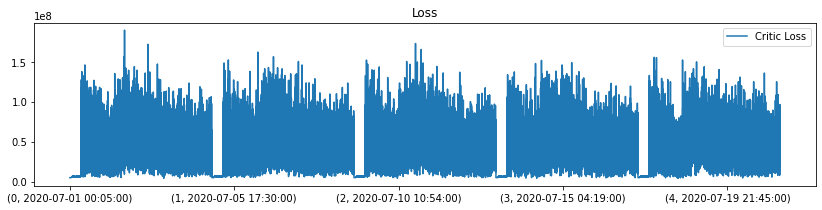

In [61]:
loss_df.plot(title="Loss", figsize=(14,3))

<AxesSubplot:title={'center':'Number of manual setpoint changes'}>

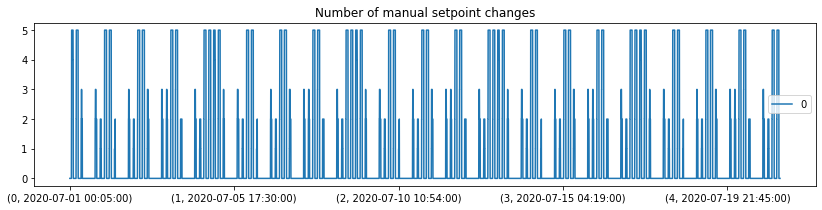

In [62]:
n_manual_stp_ch.plot(title="Number of manual setpoint changes", figsize=(14,3))

<AxesSubplot:title={'center':'Rewards'}>

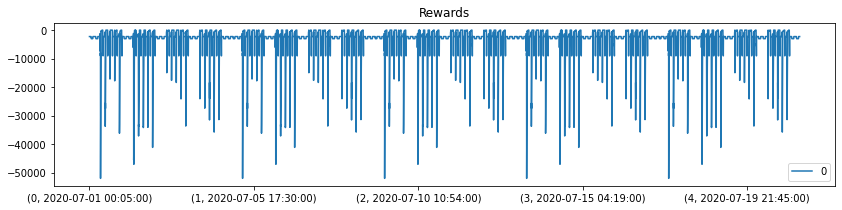

In [63]:
rewards.plot(title="Rewards", figsize=(14,3))

In [ ]:
occupancy_absolute.plot(title="Indoor occupancy", ylabel="Number of people")

In [ ]:
occupancy_meantemp.plot(title="comfort temperature", ylabel="°C", ylim=[17,25])

In [ ]:
room_temp.plot(title="Indoor temperature", ylabel="°C")

In [ ]:
humidity.plot(title="Indoor humidity", ylabel="%")

In [ ]:
co2_ppm.plot(title="Indoor CO2 concentration", ylabel="ppm")

In [ ]:
(energy/3600000).plot(ylabel="kWh", title="Energieverbrauch")

In [ ]:
outd_temp.plot(ylabel="°C", title="Outdoor temerature")

In [ ]:
outd_humi.plot(ylabel="%", title="Outdoor humidity")

In [ ]:
outd_wind_speed.plot(title="Wind speed")

In [ ]:
outd_wind_dir.plot(title="Wind direction")

In [ ]:
outd_solar_radi.plot(title="Solar radiation")

In [ ]:
# controllable elements

In [ ]:
vav_pos.plot()